# Preprocessing of single-cell paired heavy-light chain data (examine data quality, filter for true cells, filter for singlets)

Here, we preprocess the single-cell paired heavy-light chain data. We start by examining simple metrics of data quality (number of cells detected, reads or UMIs per cell). Then, we examine how many heavy and light chain contigs are assembled per cell. Based on this, we filter for bona fide singlet B cells (which have a single heavy and single light chain contig).

In [2]:
import sys
import os
import time
import random
import copy
import math

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 500
   }
mpl.rcParams.update(params)

sns.set_style("ticks")

savefig_args = {"dpi": 500, "bbox_inches": "tight", "pad_inches": 0.05}
mpl.rc('savefig', dpi=500)
output_dir = "outs"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

data_dir = "../data/"

In [3]:
sample_to_color = {"023-002_D7_Lane1": "#cbc9e2",
                   "023-002_D7_Lane2": "#9e9ac8",
                   "023-002_D7_Lane3": "#756bb1",
                   "023-002_D7_Lane4": "#54278f",
                   "023-002_D7_Lane5": "#fcae91",
                   "023-002_D7_Lane6": "#fb6a4a",
                   "023-002_D7_Lane7": "#de2d26",
                   "023-002_D7_Lane8": "#a50f15",
                   "023-002_D7_Lane9": "#deebf7",
                   "023-002_D7_Lane10": "#9ecae1",
                   "023-002_D7_Lane11": "#4292c6",
                   "023-002_D7_Lane12": "#084594",
                   "023-002_D9_Lane1": "#bae4b3",
                   "023-002_D9_Lane2": "#74c476",                   
                   "023-002_D9_Lane3": "#31a354",                   
                   "023-002_D9_Lane4": "#006d2c"}

# Load data: summary metrics and contig annotations

In [4]:
# Summary metrics for each 10X lane

infile = data_dir+"cell_ranger_metrics_summary.csv"
df_metrics_summary = pd.read_csv(infile, header=0, thousands=',')
print df_metrics_summary.shape
df_metrics_summary

(16, 38)


,sample,Estimated Number of Cells,Mean Read Pairs per Cell,Number of Cells With Productive V-J Spanning Pair,Number of Read Pairs,Valid Barcodes,Q30 Bases in Barcode,Q30 Bases in RNA Read 1,Q30 Bases in RNA Read 2,Q30 Bases in Sample Index,Q30 Bases in UMI,Reads Mapped to Any V(D)J Gene,Reads Mapped to IGH,Reads Mapped to IGK,Reads Mapped to IGL,Cell Count Confidence,Mean Used Read Pairs per Cell,Fraction Reads in Cells,Median IGH UMIs per Cell,Median IGK UMIs per Cell,Median IGL UMIs per Cell,Cells With Productive V-J Spanning Pair,"Cells With Productive V-J Spanning (IGK, IGH) Pair","Cells With Productive V-J Spanning (IGL, IGH) Pair",Paired Clonotype Diversity,Cells With IGH Contig,Cells With IGK Contig,Cells With IGL Contig,Cells With CDR3-annotated IGH Contig,Cells With CDR3-annotated IGK Contig,Cells With CDR3-annotated IGL Contig,Cells With V-J Spanning IGH Contig,Cells With V-J Spanning IGK Contig,Cells With V-J Spanning IGL Contig,Cells With Productive IGH Contig,Cells With Productive IGK Contig,Cells With Productive IGL Contig,Contigs Unannotated
0,023-002_D9_Lane1,395,167795,346,66279271,97.9%,96.2%,82.4%,83.6%,95.2%,96.1%,97.2%,38.1%,35.8%,19.4%,100.0%,90250,98.6%,12.0,27.0,25.0,87.6%,42.8%,46.3%,326.55,94.2%,53.7%,52.2%,91.4%,50.9%,50.6%,92.9%,52.4%,51.4%,90.4%,47.8%,49.1%,0.0%
1,023-002_D9_Lane2,5404,16951,4873,91603639,97.4%,96.5%,83.3%,84.3%,95.4%,96.5%,96.7%,42.6%,31.9%,17.7%,99.3%,15849,98.7%,14.0,27.0,26.0,90.2%,49.4%,44.2%,4432.50,98.3%,58.3%,53.9%,94.6%,55.7%,49.6%,95.7%,56.5%,50.3%,92.7%,53.2%,47.6%,0.0%
2,023-002_D9_Lane3,6235,14033,5606,87498140,97.6%,96.4%,83.0%,84.0%,95.3%,96.4%,96.7%,45.2%,30.2%,16.9%,99.8%,12762,98.9%,14.0,25.0,26.0,89.9%,49.6%,43.8%,5302.41,98.4%,58.8%,53.4%,94.9%,56.1%,48.5%,96.0%,57.3%,49.5%,93.0%,53.2%,46.7%,0.0%
3,023-002_D9_Lane4,6741,11609,5982,78257238,97.8%,96.4%,83.0%,84.3%,95.0%,96.4%,96.7%,43.5%,31.9%,16.9%,98.7%,10744,98.8%,12.0,23.0,24.0,88.7%,48.0%,44.5%,5413.03,98.0%,57.9%,54.5%,93.7%,54.9%,49.6%,95.3%,56.2%,50.6%,91.9%,52.2%,47.9%,0.0%
4,023-002_D7_Lane1,9841,6051,8585,59552919,97.7%,94.3%,78.2%,81.1%,93.3%,93.9%,96.4%,38.1%,37.1%,17.2%,98.7%,5585,98.4%,11.0,23.0,21.0,87.2%,49.1%,43.0%,8038.67,97.5%,60.0%,54.6%,92.7%,57.0%,49.3%,93.1%,57.6%,49.8%,90.3%,54.1%,47.2%,0.0%
5,023-002_D7_Lane2,9575,6367,8342,60964510,97.8%,94.4%,78.4%,81.2%,93.7%,94.0%,96.6%,38.3%,37.4%,17.0%,98.7%,5872,97.9%,11.0,21.0,19.0,87.1%,49.6%,42.8%,7776.40,97.8%,59.6%,53.9%,92.8%,56.9%,49.1%,93.2%,57.5%,49.5%,90.2%,54.7%,47.1%,0.0%
6,023-002_D7_Lane3,9629,6224,8365,59932358,97.7%,94.3%,78.3%,81.1%,92.9%,93.9%,96.6%,38.2%,36.9%,17.6%,98.7%,5732,97.7%,10.0,21.0,20.0,86.9%,49.7%,43.2%,7741.20,97.3%,60.2%,54.8%,92.3%,57.4%,50.0%,93.0%,58.0%,50.3%,90.0%,54.8%,47.9%,0.0%
7,023-002_D7_Lane4,9104,7738,7991,70450162,97.8%,94.5%,78.5%,81.0%,93.7%,94.0%,96.7%,39.1%,37.3%,16.6%,99.0%,7081,98.1%,11.0,21.0,20.0,87.8%,49.9%,43.3%,7445.33,97.7%,60.1%,54.4%,93.2%,57.5%,49.3%,94.0%,58.1%,49.7%,91.1%,54.6%,47.1%,0.0%
8,023-002_D7_Lane5,8968,7785,7915,69816962,97.7%,94.5%,78.6%,81.3%,92.8%,94.1%,96.7%,38.7%,36.1%,18.0%,99.0%,7021,98.0%,12.0,25.0,23.0,88.3%,50.8%,43.2%,7325.73,97.8%,60.8%,53.8%,93.8%,58.0%,48.9%,93.8%,58.6%,49.2%,91.3%,55.3%,47.0%,0.0%
9,023-002_D7_Lane6,9396,6030,8201,56663082,97.7%,94.3%,78.3%,80.9%,92.1%,93.9%,96.5%,38.3%,37.4%,16.9%,98.7%,5512,97.2%,10.0,21.0,20.0,87.3%,49.9%,43.5%,7595.19,97.5%,60.8%,54.3%,92.9%,57.9%,49.4%,93.0%,58.6%,49.9%,90.2%,55.5%,47.5%,0.0%


In [5]:
# Contigs with annotations

infile = data_dir+"all_contig_annotations.csv"
df_all_contig_annotations = pd.read_csv(infile, header=0)
print df_all_contig_annotations.shape
df_all_contig_annotations.head()

(677500, 19)


,sample,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
0,023-002_D9_Lane1,AAACGGGGTAAGCACG-1,True,AAACGGGGTAAGCACG-1_contig_1,True,675,IGH,IGHV5-51,IGHD1-26,IGHJ6,IGHG1,True,False,CSTVRDGVGPTPSYYYHVMDVW,TGTAGTACTGTGCGAGACGGGGTGGGACCTACACCGTCCTACTACT...,25041,6,clonotype9,None
1,023-002_D9_Lane1,AAACGGGGTAAGCACG-1,True,AAACGGGGTAAGCACG-1_contig_2,True,578,IGK,IGKV3-11,None,IGKJ4,IGKC,True,True,CQQRSNWPVGVTF,TGTCAGCAGCGTAGCAACTGGCCCGTCGGAGTCACTTTC,129116,27,clonotype9,clonotype9_consensus_1
2,023-002_D9_Lane1,AAAGCAAAGTTTGCGT-1,True,AAAGCAAAGTTTGCGT-1_contig_1,True,549,IGK,IGKV3-20,None,IGKJ4,IGKC,True,True,CQQFNAF,TGTCAGCAGTTTAACGCCTTC,89938,14,clonotype10,clonotype10_consensus_1
3,023-002_D9_Lane1,AAAGCAAAGTTTGCGT-1,True,AAAGCAAAGTTTGCGT-1_contig_2,True,673,IGH,IGHV3-7,IGHD1-14,IGHJ4,IGHA1,True,True,CVRDWPPDTVITENLHDLW,TGTGTGAGAGATTGGCCCCCAGACACGGTCATAACCGAAAATTTAC...,36138,5,clonotype10,clonotype10_consensus_2
4,023-002_D9_Lane1,AAAGCAACAATGAAAC-1,True,AAAGCAACAATGAAAC-1_contig_1,True,571,IGK,IGKV3-15,None,IGKJ4,IGKC,True,True,CQQYNNWPPLTF,TGTCAGCAGTATAATAACTGGCCTCCGCTCACTTTC,132171,47,clonotype11,clonotype11_consensus_2


# Plot summary metrics (reads, cells, reads/cell, productive IGH)

Text(0,0.5,'% Cells With\nProductive IGH Contig')

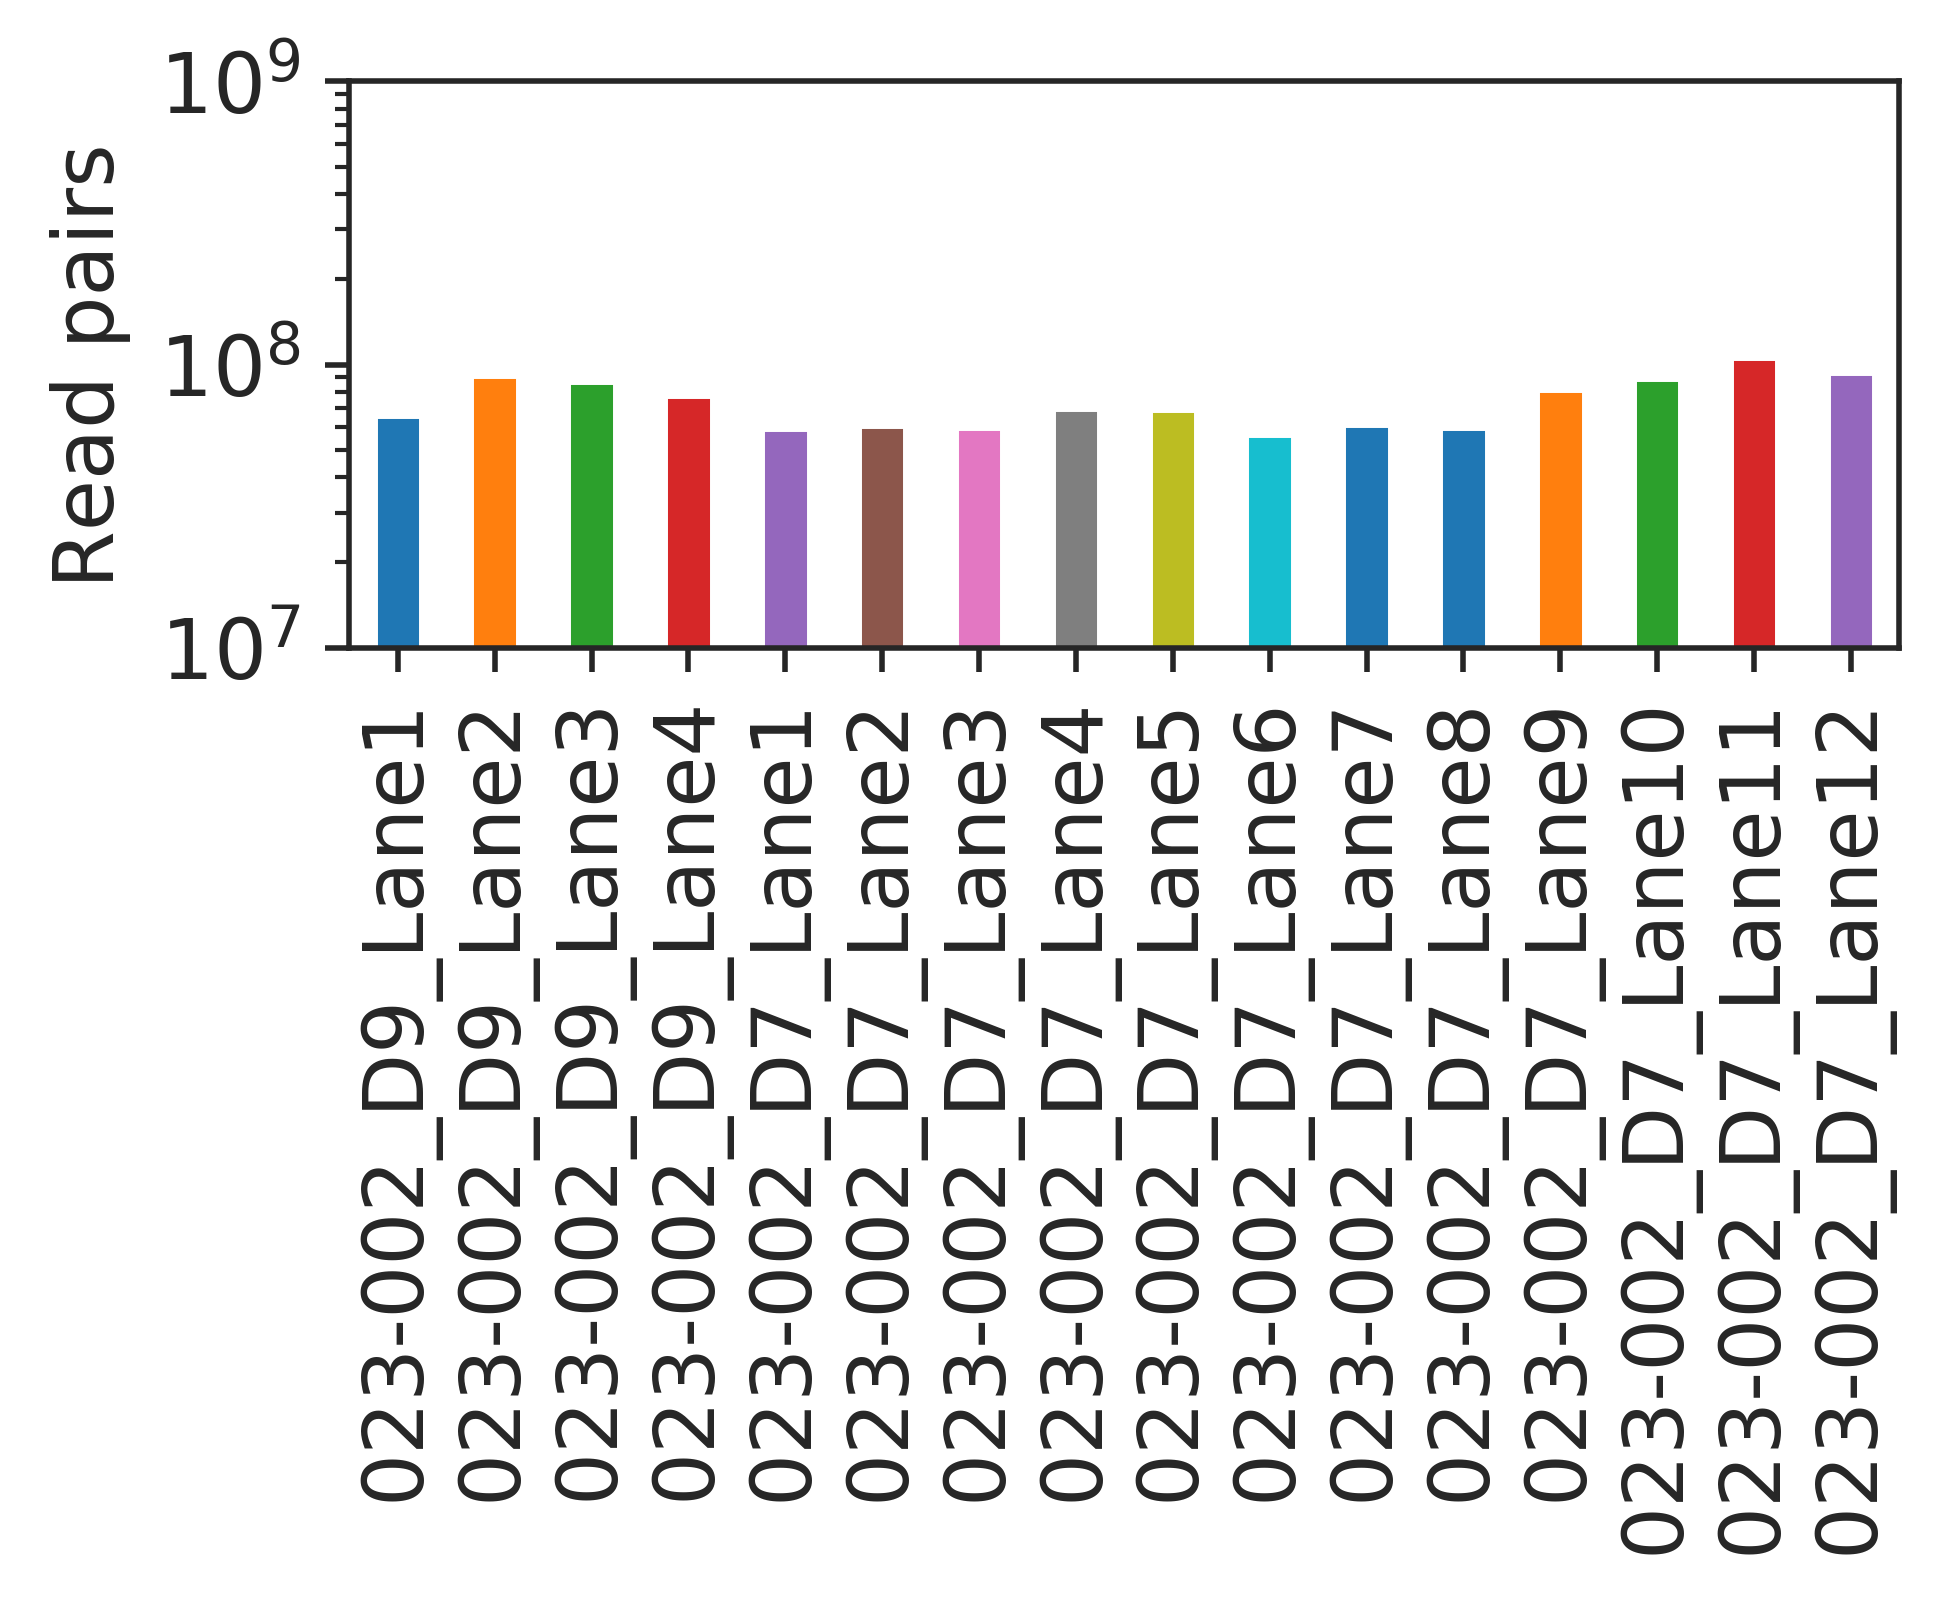

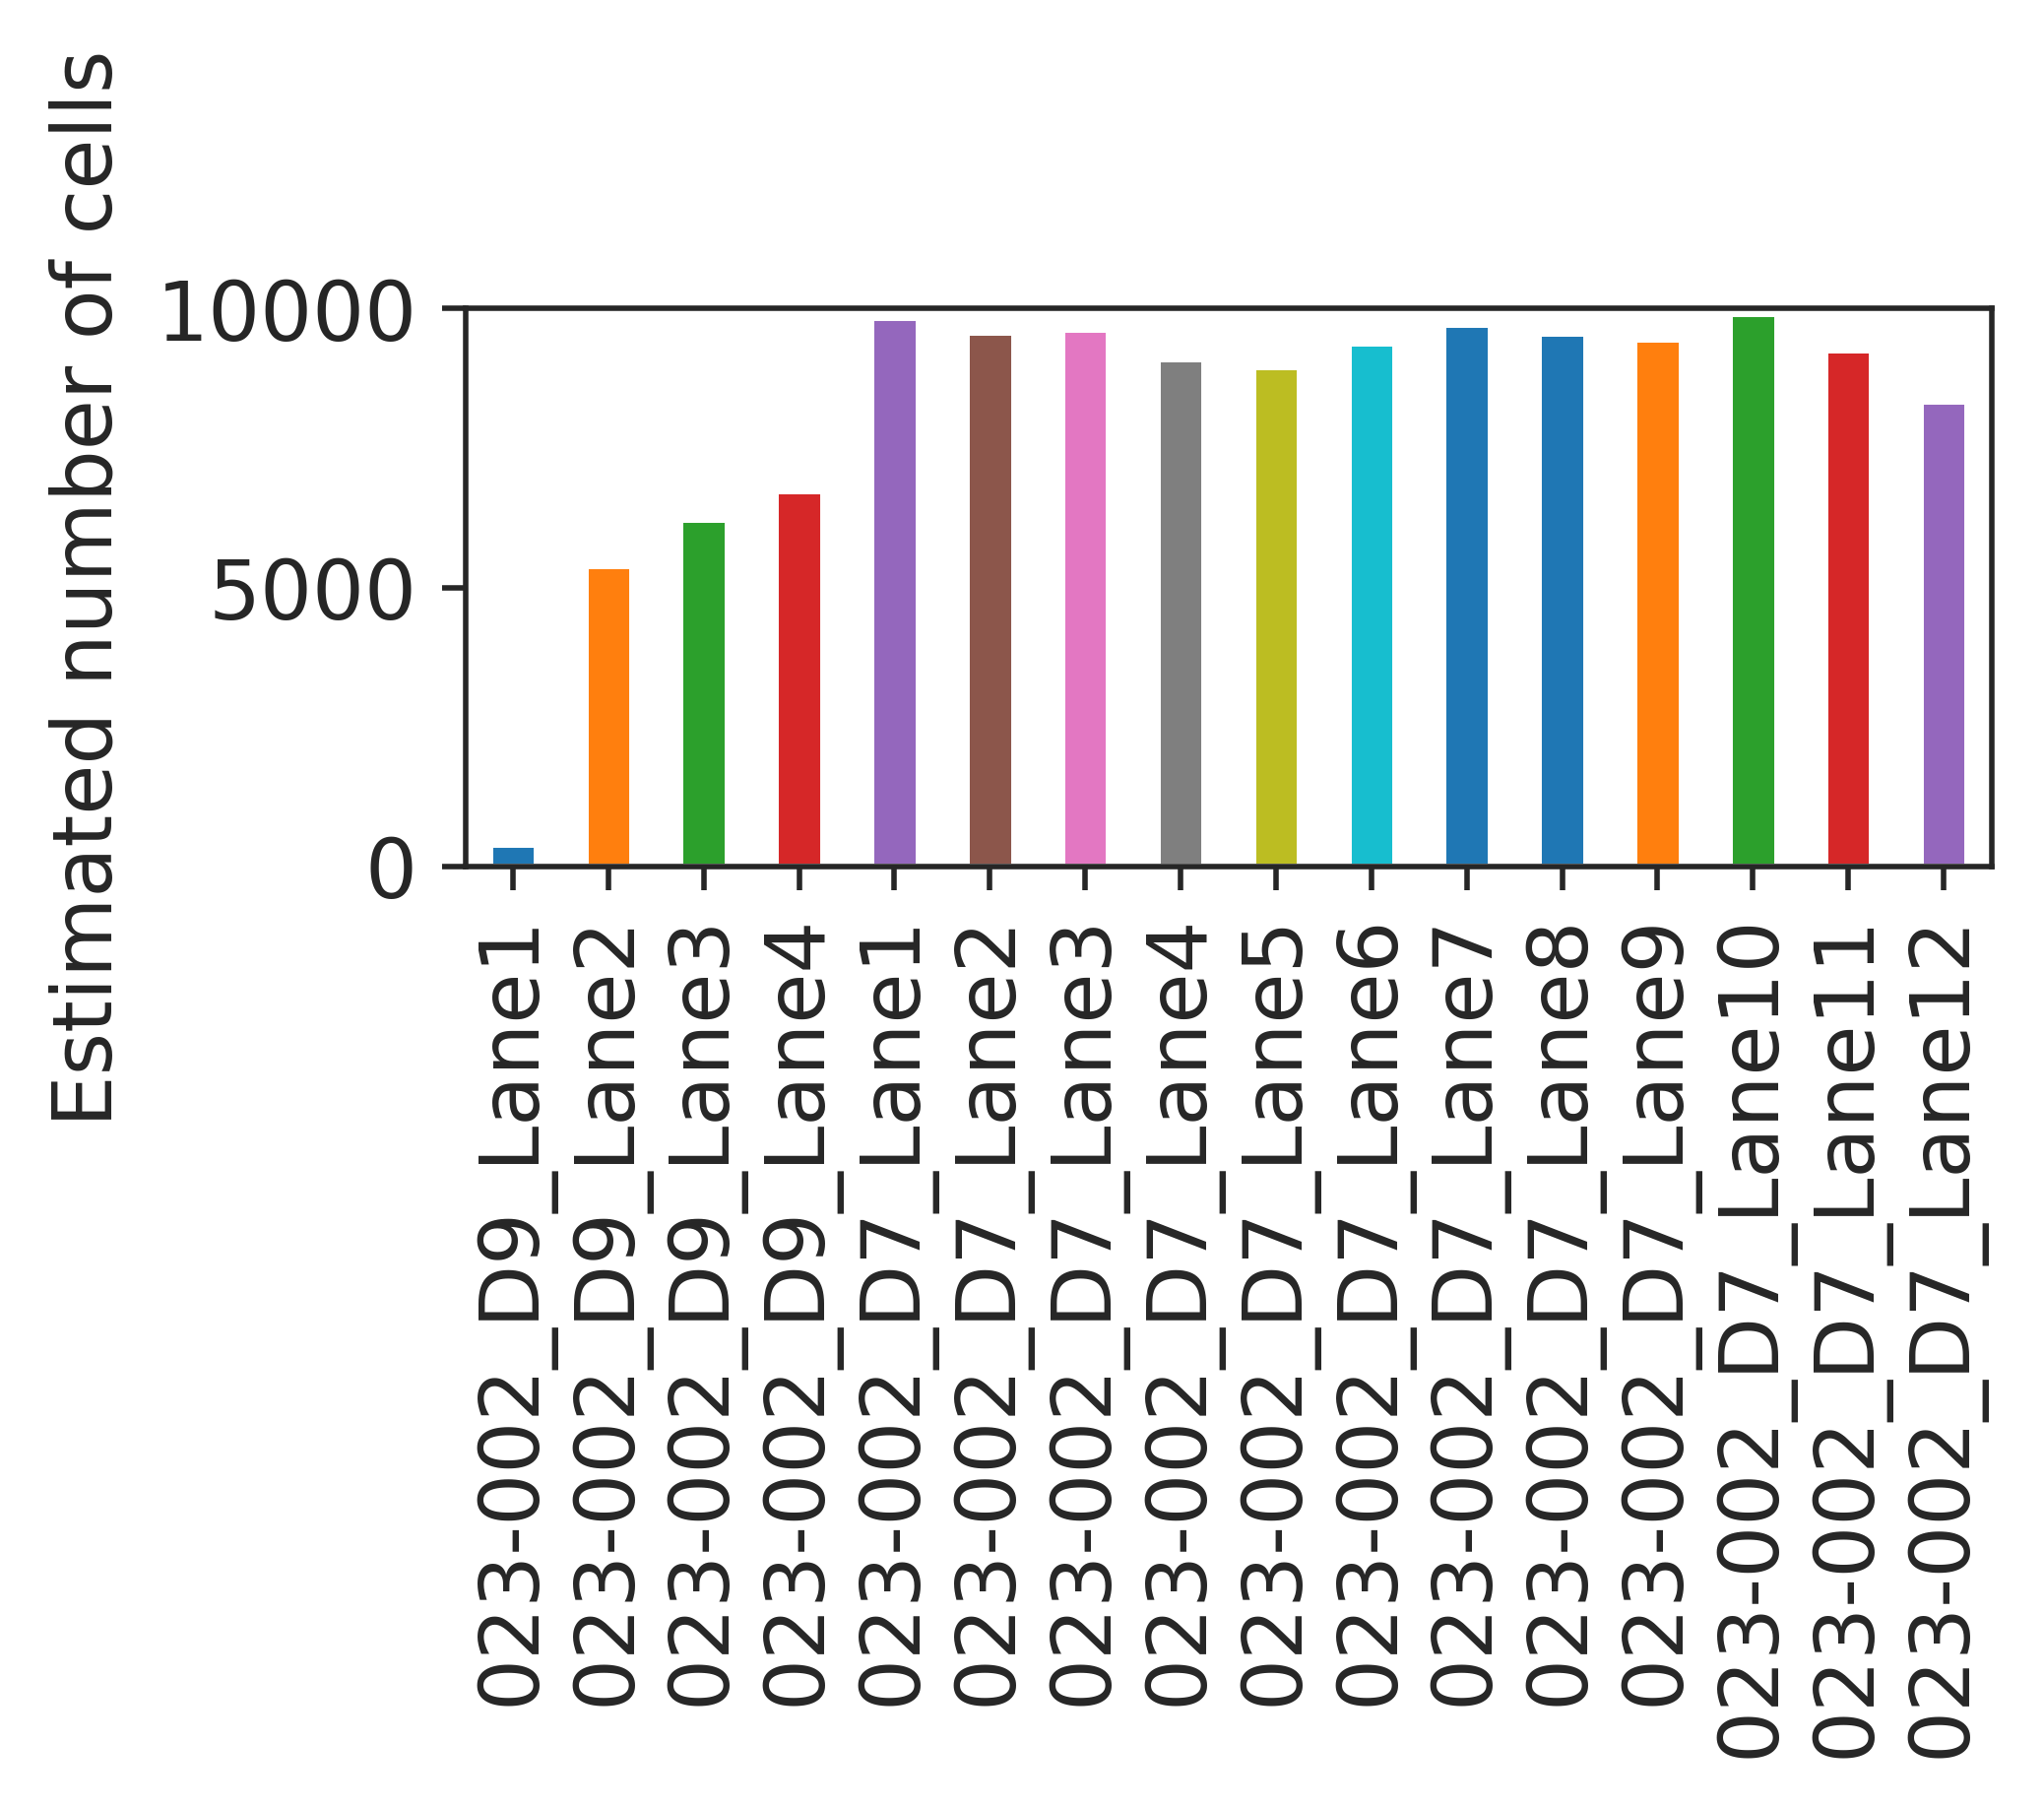

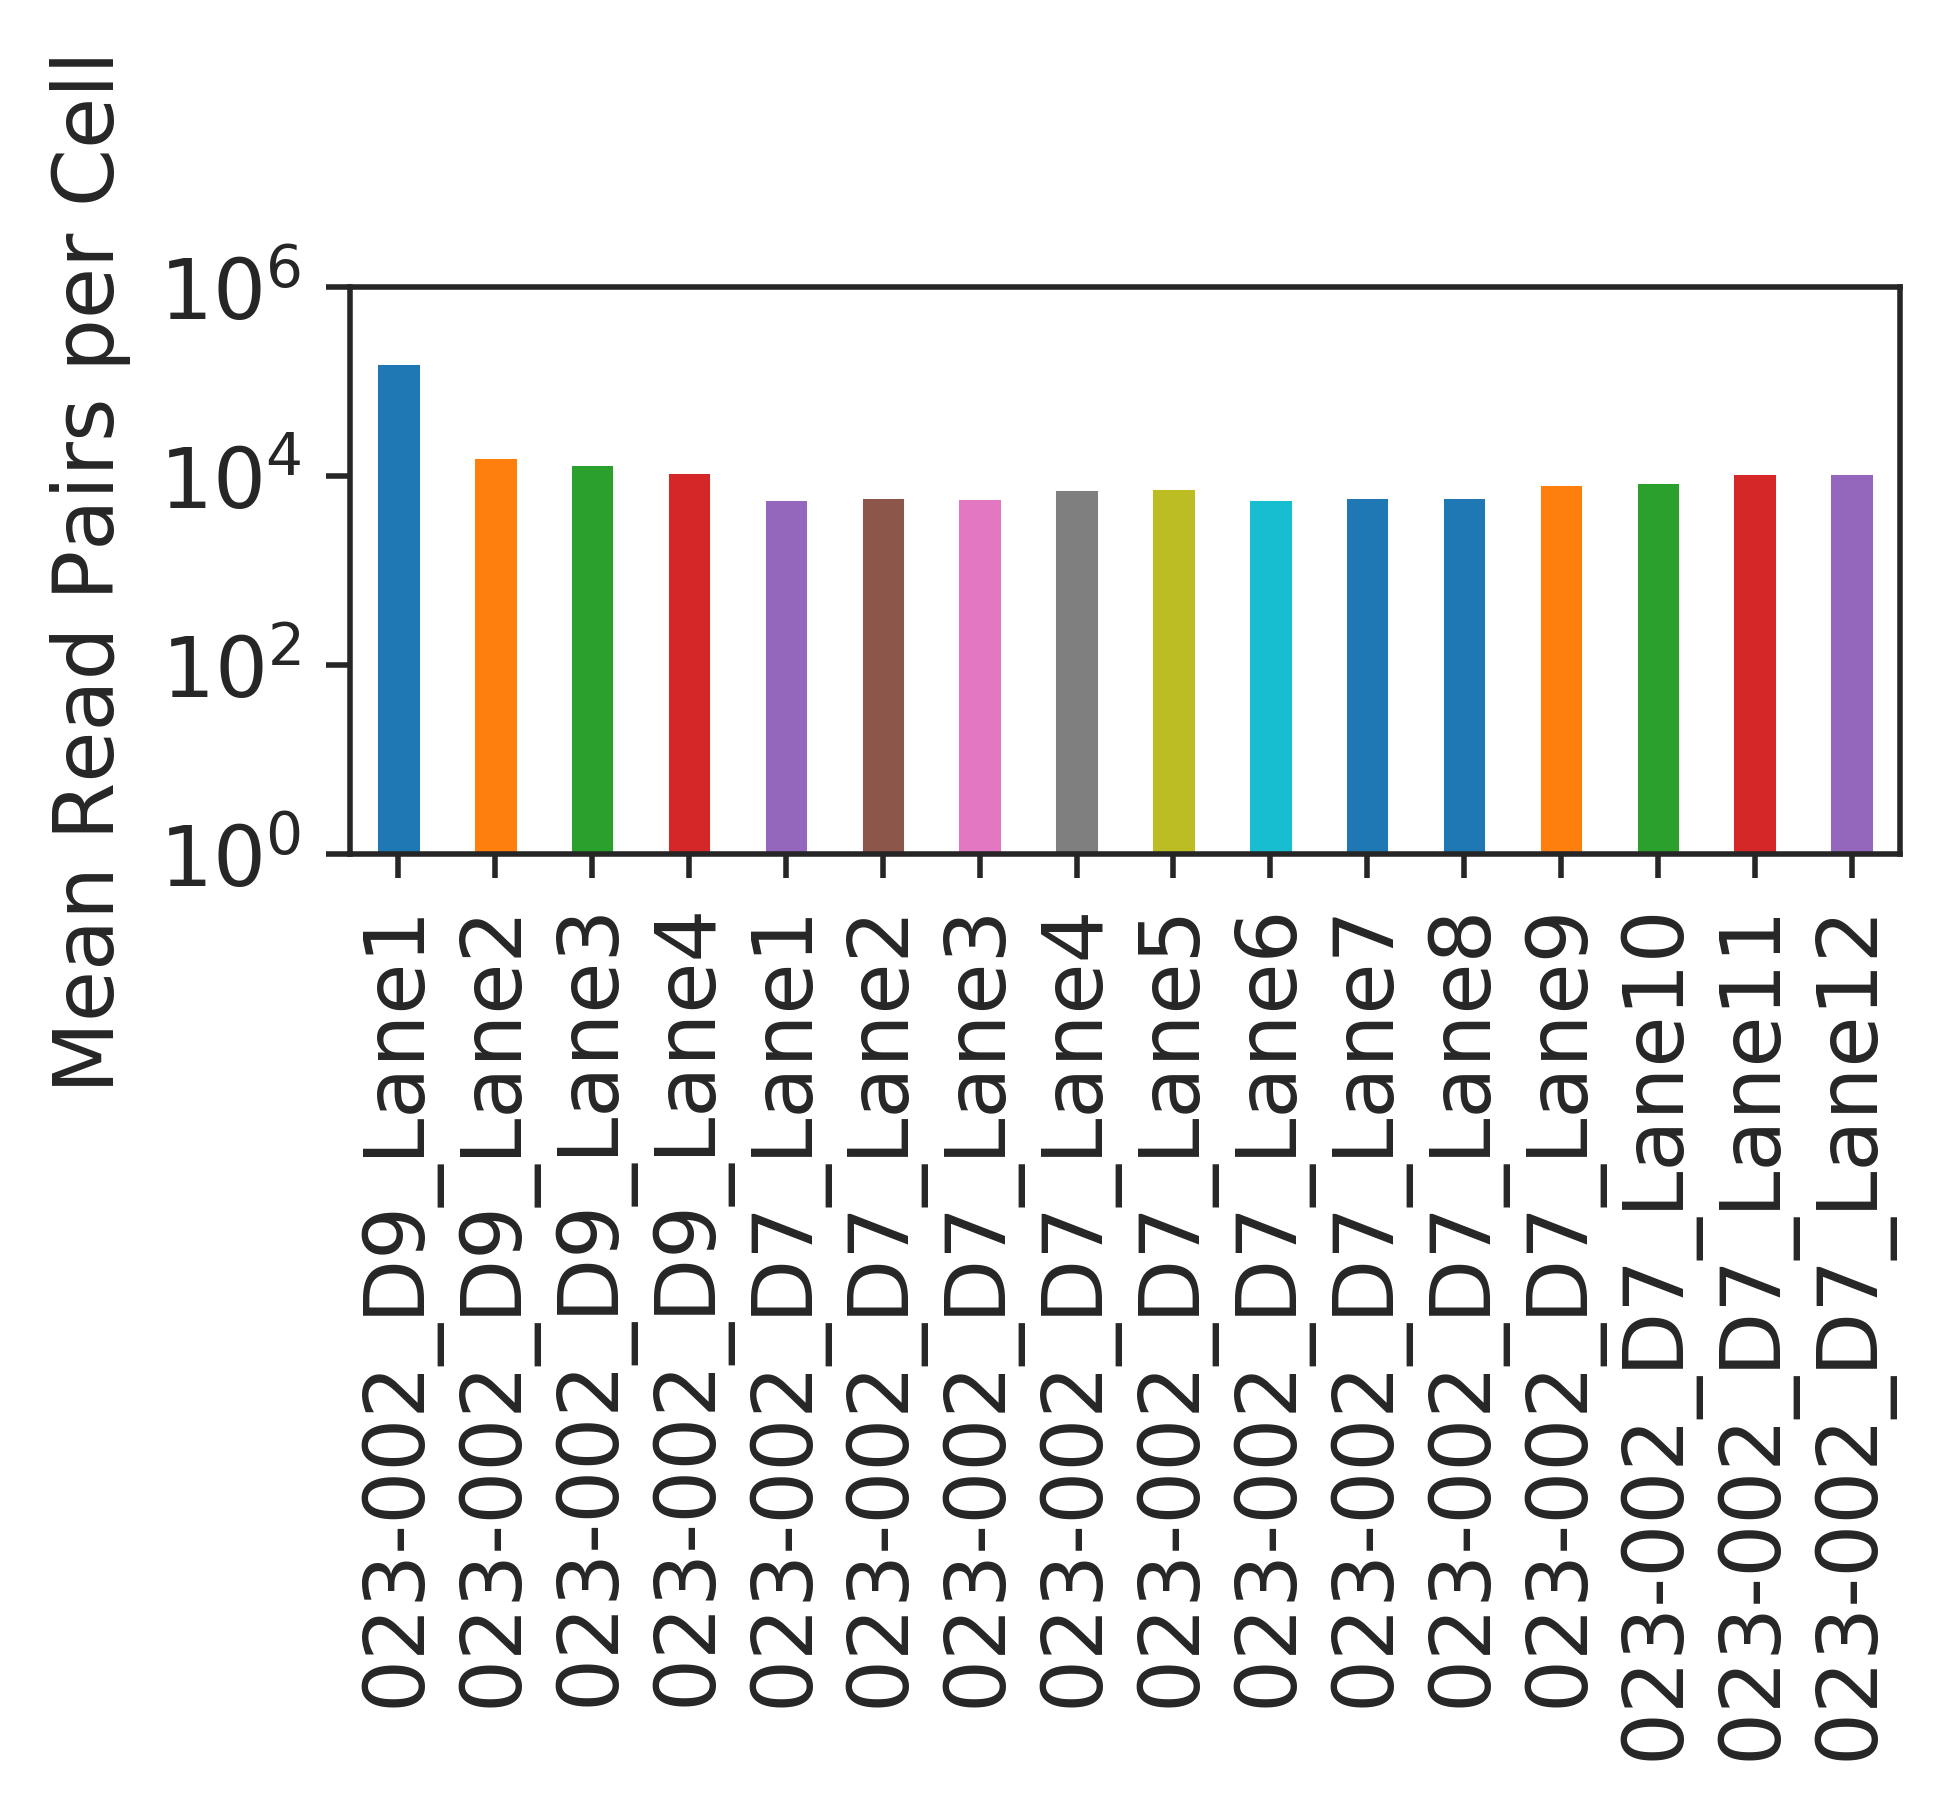

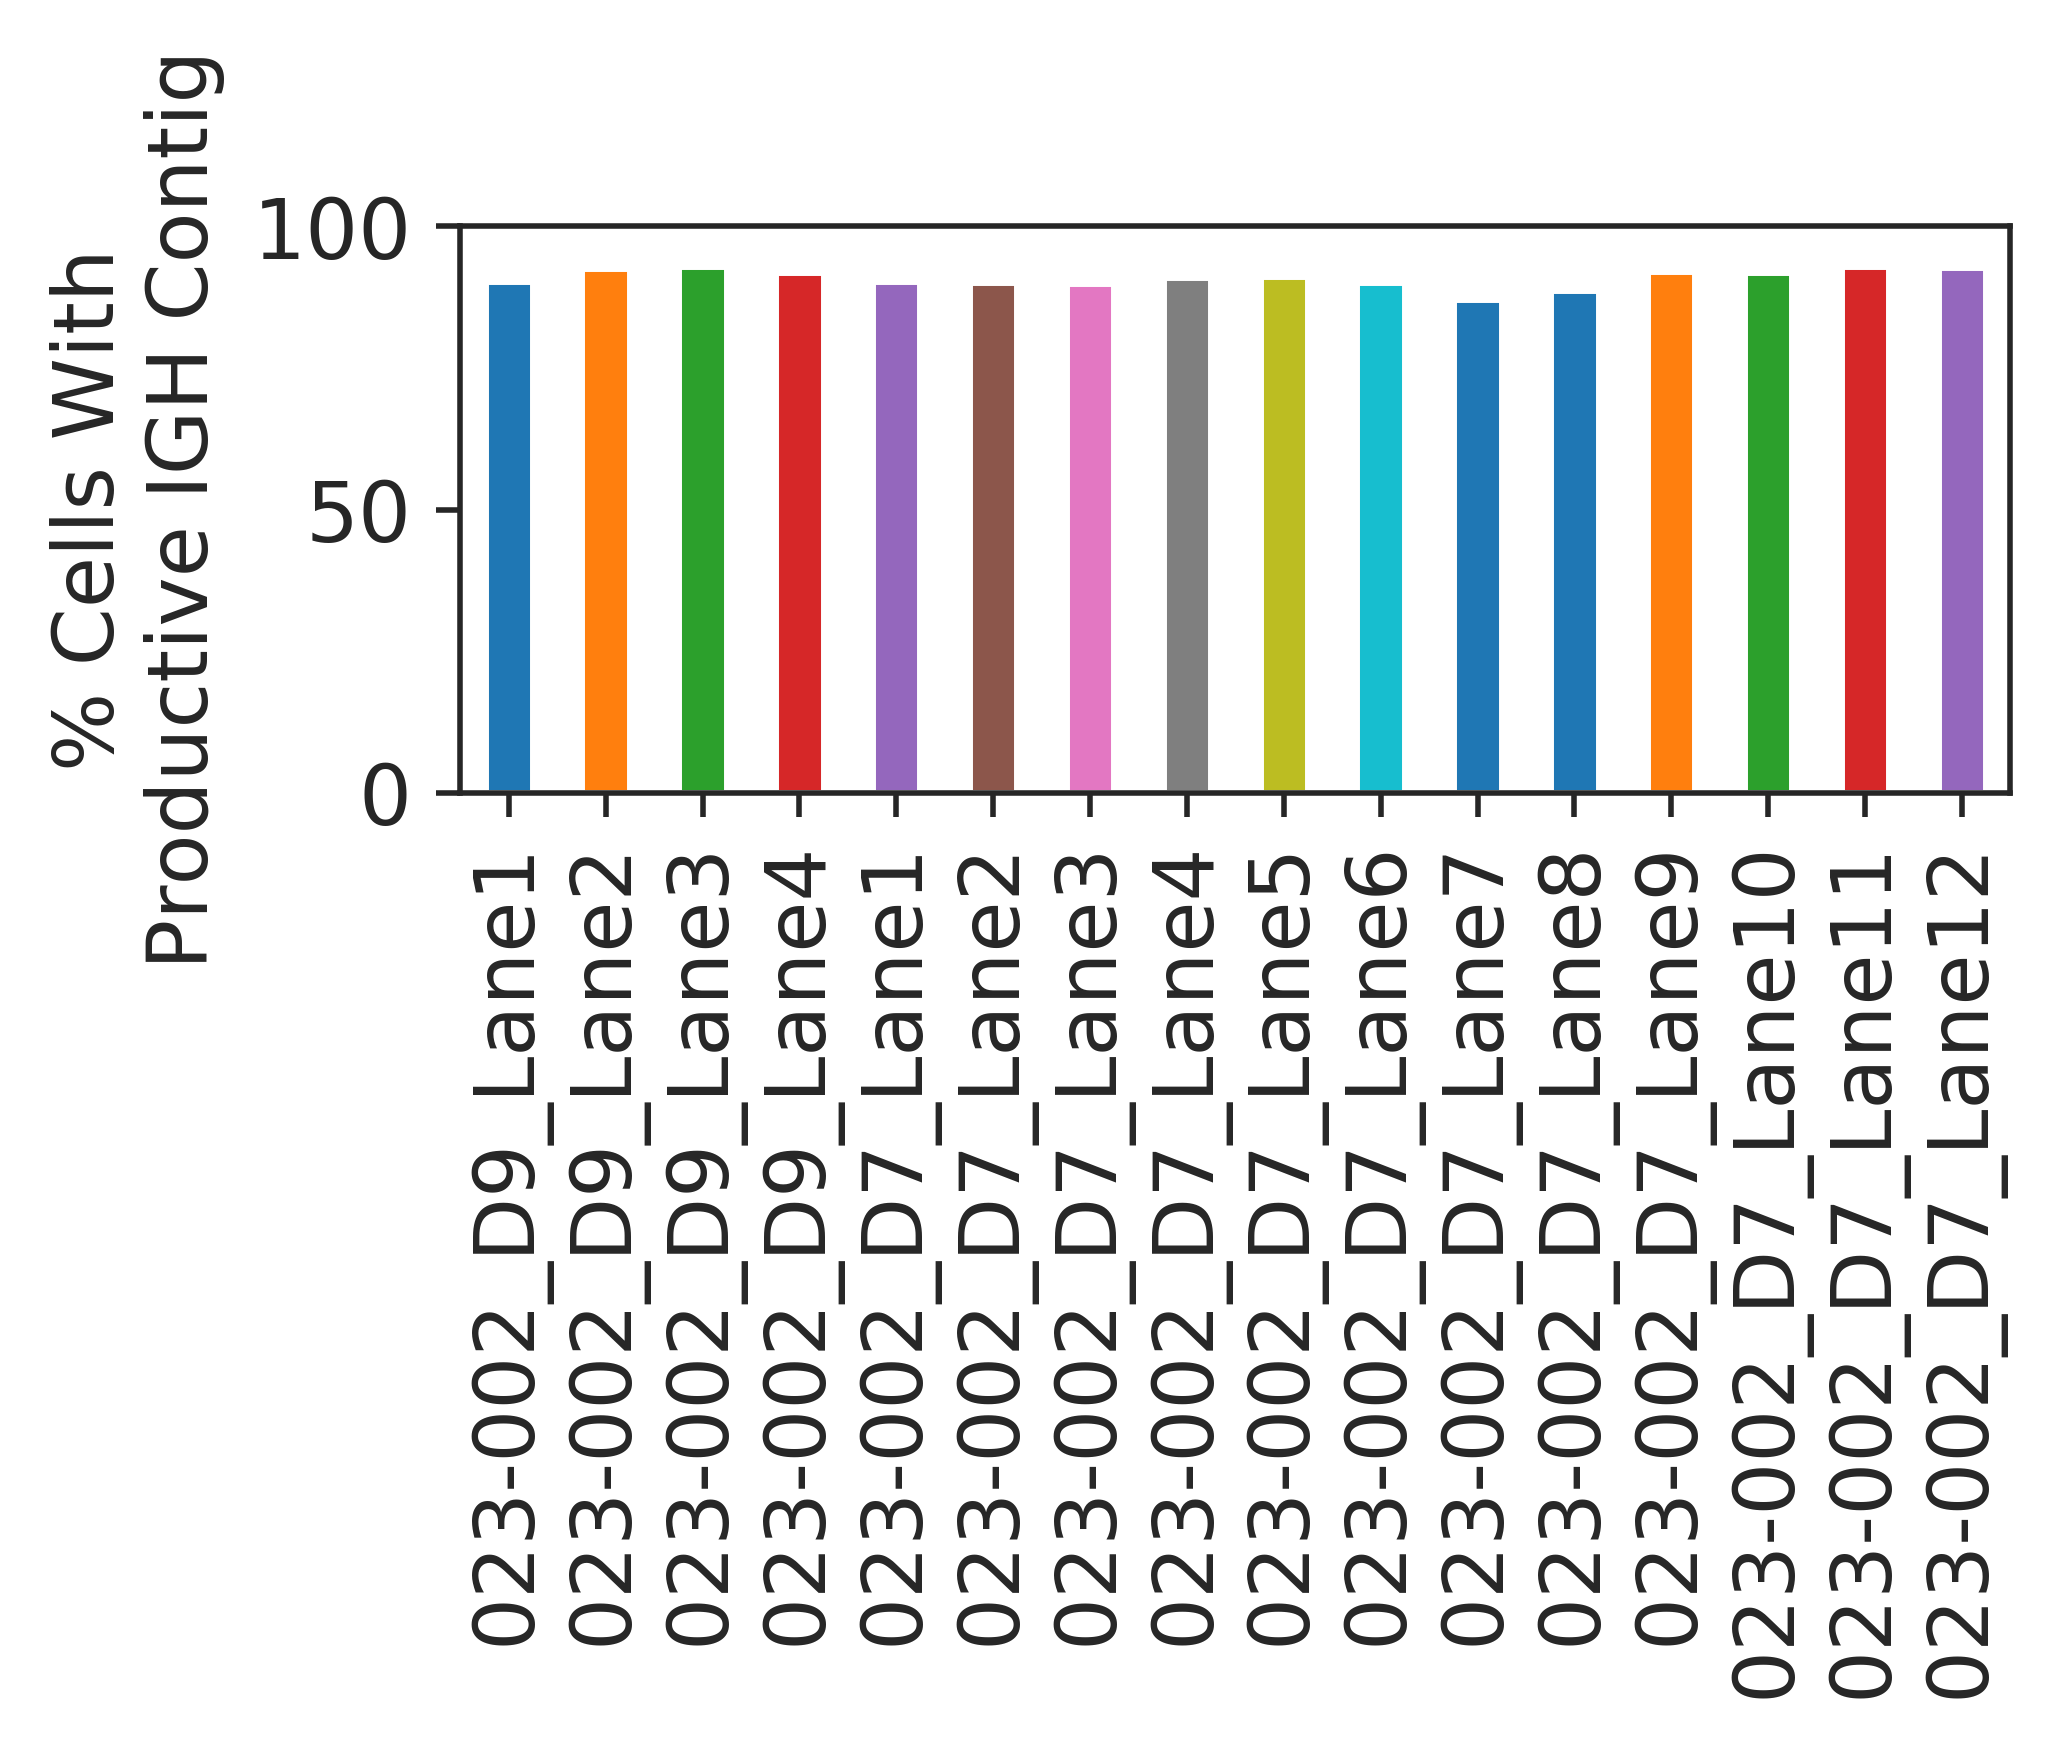

In [6]:
# Per lane

# Reads

fig, ax = plt.subplots(1, 1, figsize=(4,1.5))
df_metrics_summary["Number of Read Pairs"].plot(kind="bar", ax=ax)
ax.set_yscale("log")
ax.set_ylim(1e7, 1e9)
ax.set_xticklabels(df_metrics_summary["sample"])
ax.set_ylabel("Read pairs")

# Cells

fig, ax = plt.subplots(1, 1, figsize=(4,1.5))
df_metrics_summary["Estimated Number of Cells"].plot(kind="bar", ax=ax)
ax.set_ylim(0, 1e4)
ax.set_xticklabels(df_metrics_summary["sample"])
ax.set_ylabel("Estimated number of cells")

# Mean Read Pairs per Cell

fig, ax = plt.subplots(1, 1, figsize=(4,1.5))
df_metrics_summary["Mean Read Pairs per Cell"].plot(kind="bar", ax=ax)
ax.set_yscale("log")
ax.set_ylim(1, 1e6)
ax.set_xticklabels(df_metrics_summary["sample"])
ax.set_ylabel("Mean Read Pairs per Cell")

# Cells With Productive IGH Contig

fig, ax = plt.subplots(1, 1, figsize=(4,1.5))
df_metrics_summary["Cells With Productive IGH Contig"].str.rstrip('%').astype('float').plot(kind="bar", ax=ax)
ax.set_ylim(0, 100)
ax.set_xticklabels(df_metrics_summary["sample"])
ax.set_ylabel("% Cells With\nProductive IGH Contig")

In [7]:
# As average across all lanes


# Filter for high-quality contigs (using productive flag)

In [8]:
# Count total contigs assembled per cell
df_contig_aggr = df_all_contig_annotations.groupby(["sample", "barcode", "chain"]).size().unstack(fill_value=0)
print df_contig_aggr.shape
df_contig_aggr.head()

(220200, 9)


chain                                IGH  IGK  IGL  Multi  None  TRA  TRB  TRD  TRG
sample           barcode                                                           
023-002_D7_Lane1 AAACCTGAGATGTGGC-1    1    0    1      1     0    0    0    0    0
                 AAACCTGAGCCGTCGT-1    1    1    0      1     0    0    0    0    0
                 AAACCTGAGGACTGGT-1    1    0    0      0     0    0    0    0    0
                 AAACCTGAGGCGCTCT-1    1    1    0      1     0    0    0    0    0
                 AAACCTGAGTTAACGA-1    2    0    1      2     0    0    0    0    0

In [9]:
# Total number of each type of contig
print np.sum(df_contig_aggr, axis=0)

chain
IGH      229701
IGK      146114
IGL      147193
Multi    132355
None         10
TRA        2562
TRB       19418
TRD          24
TRG         123
dtype: int64


In [10]:
# Filter for productive contigs (implies full-length, removes all TCR and None chain assignments, removes most "Multi" chain assignments)

df_contig_aggr = df_all_contig_annotations.groupby(["productive", "sample", "barcode", "chain"]).size().unstack(fill_value=0)
df_contig_aggr_filtered = df_contig_aggr.xs("True", level="productive")
print df_contig_aggr_filtered.shape
print np.sum(df_contig_aggr_filtered, axis=0)
df_contig_aggr_filtered.head()

(190502, 9)
chain
IGH      160509
IGK      114709
IGL       94029
Multi       133
None          0
TRA           0
TRB           0
TRD           0
TRG           0
dtype: int64


chain                                IGH  IGK  IGL  Multi  None  TRA  TRB  TRD  TRG
sample           barcode                                                           
023-002_D7_Lane1 AAACCTGAGATGTGGC-1    1    0    0      0     0    0    0    0    0
                 AAACCTGAGCCGTCGT-1    0    1    0      0     0    0    0    0    0
                 AAACCTGAGGACTGGT-1    1    0    0      0     0    0    0    0    0
                 AAACCTGAGGCGCTCT-1    1    1    0      0     0    0    0    0    0
                 AAACCTGAGTTAACGA-1    1    0    1      0     0    0    0    0    0

In [12]:
# In previous work, we examined the distribution of contig types (e.g. IGH, IGK, IGL, TCRA, etc.)
# within subsets having various annotations (Productive, full length, high confidence, etc.).
# The conclusion was that the productive flag is sufficient to filter for high quality contigs.
# For instance, we found: All productive sequences are full length. Conversely, not all full length sequences are productive.

# Examine rates of singlets and doublets (number of IGH and IGK/L contigs per cell)

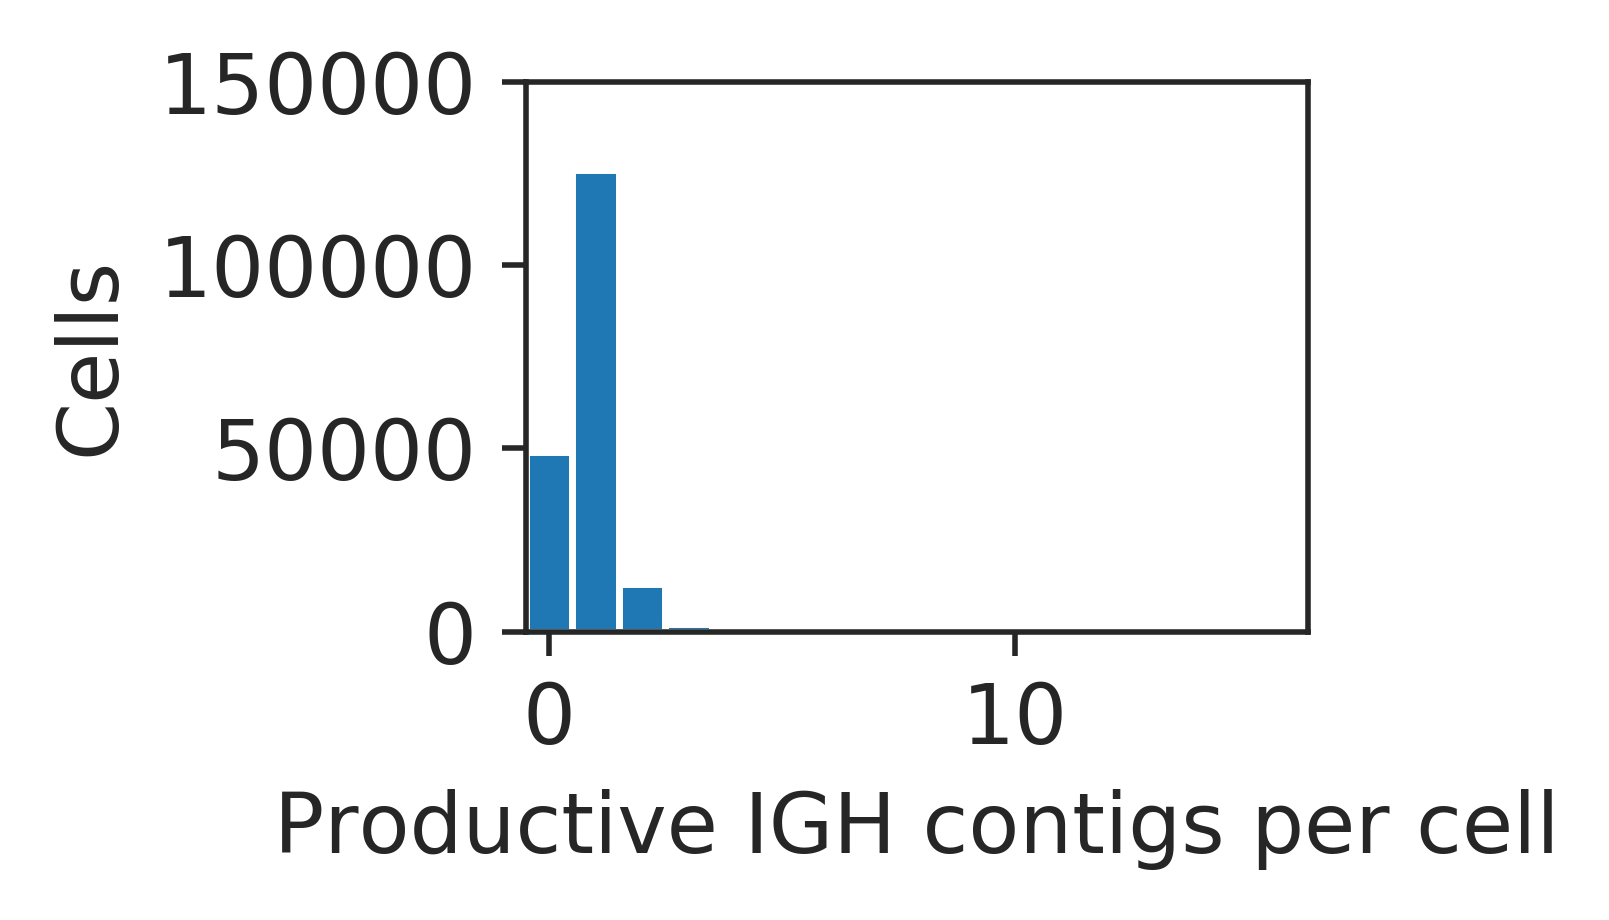

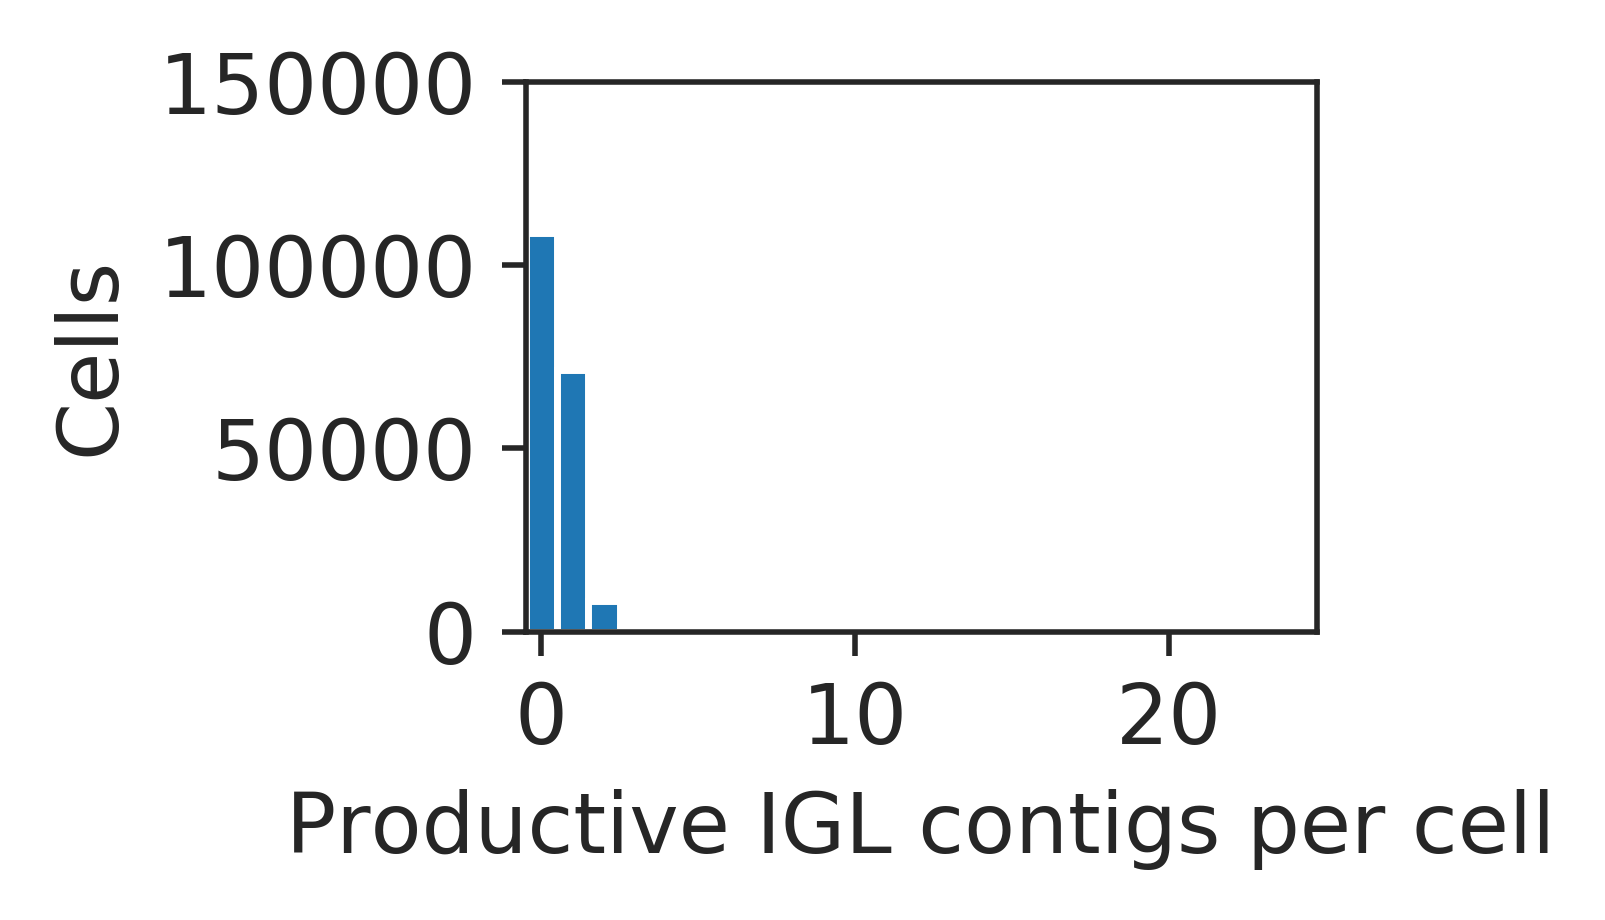

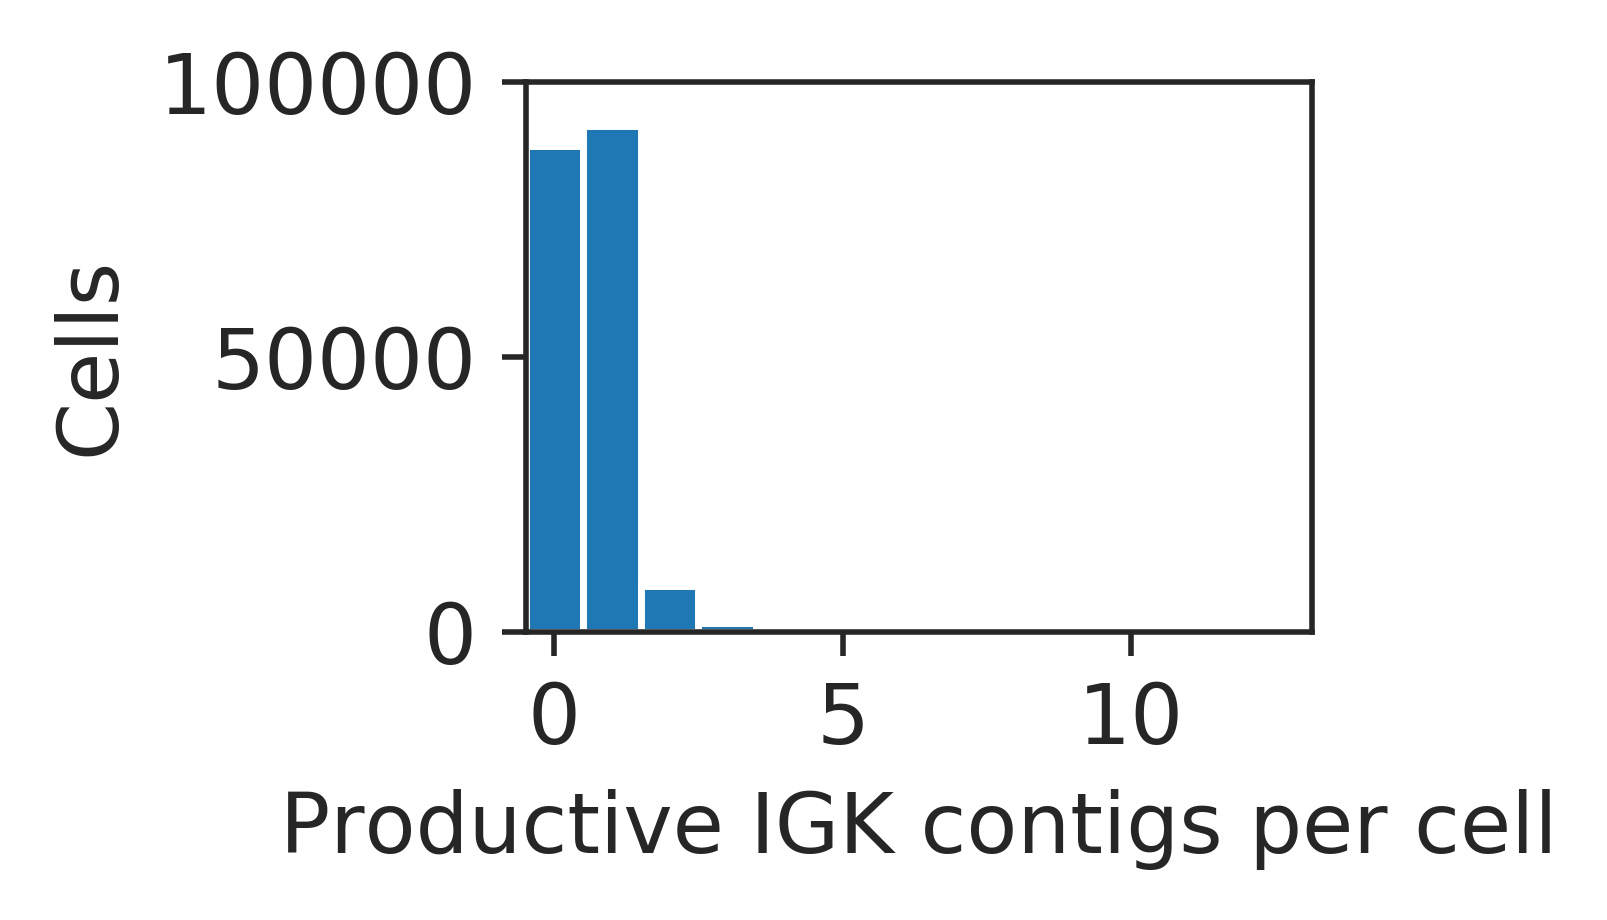

In [11]:
# Examine number of high-quality contigs assembled per cell (IGH, IGK, IGL individually)

x = df_contig_aggr_filtered["IGH"]
bins = np.array(range(max(x)+2))-0.5

fig, ax = plt.subplots(1, 1, figsize=(3,2))
ax.hist(x, bins=bins)
# ax.set_yscale("log")
ax.set_xlim(left=-0.5)
ax.set_ylim(0, 150000)
ax.set_xlabel("Productive IGH contigs per cell")
ax.set_ylabel("Cells")
plt.tight_layout()

x = df_contig_aggr_filtered["IGL"]
bins = np.array(range(max(x)+2))-0.5

fig, ax = plt.subplots(1, 1, figsize=(3,2))
ax.hist(x, bins=bins)
# ax.set_yscale("log")
ax.set_xlim(left=-0.5)
ax.set_ylim(0, 150000)
ax.set_xlabel("Productive IGL contigs per cell")
ax.set_ylabel("Cells")
plt.tight_layout()

x = df_contig_aggr_filtered["IGK"]
bins = np.array(range(max(x)+2))-0.5

fig, ax = plt.subplots(1, 1, figsize=(3,2))
ax.hist(x, bins=bins)
# ax.set_yscale("log")
ax.set_xlim(left=-0.5)
ax.set_ylim(0, 100000)
ax.set_xlabel("Productive IGK contigs per cell")
ax.set_ylabel("Cells")
plt.tight_layout()

15 23


Text(1,1,'94259')

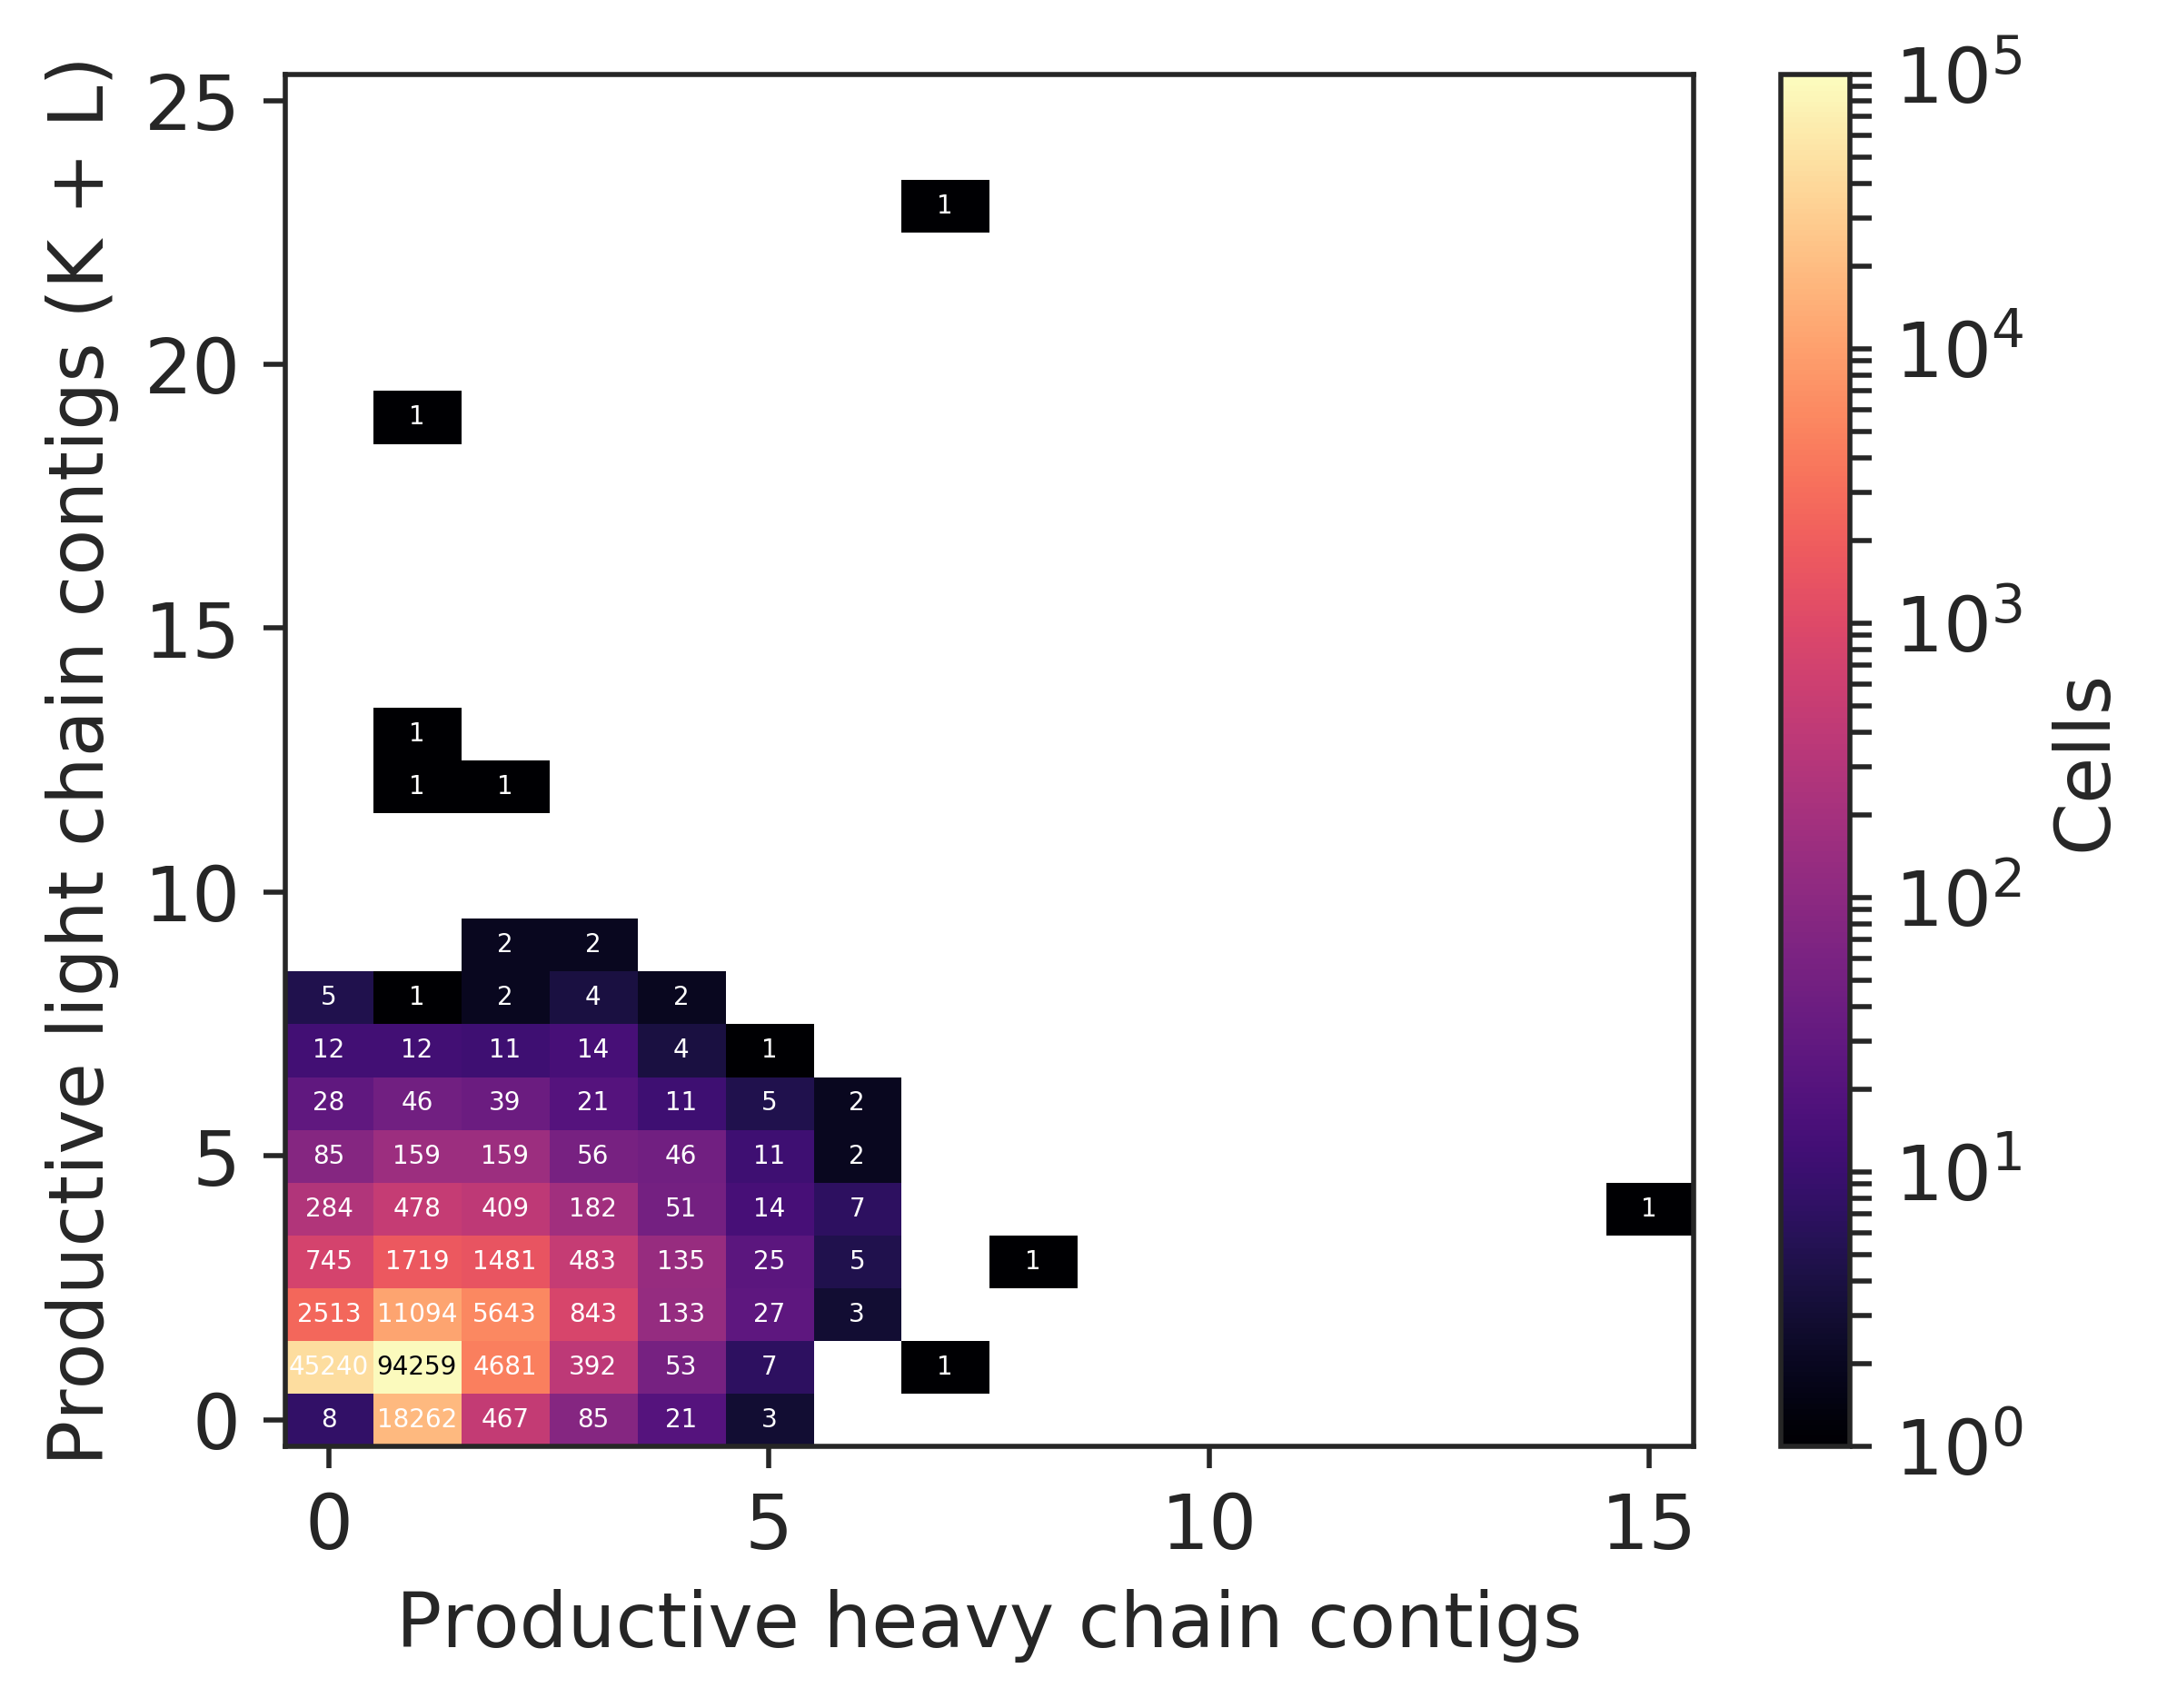

In [12]:
# Examine number of high-quality contigs assembled per cell (joint distribution of IGH, IGK/L)
# full range

x = df_contig_aggr_filtered["IGH"]
y = df_contig_aggr_filtered["IGL"] + df_contig_aggr_filtered["IGK"]

print max(x), max(y)
xbins = np.array(range(0,max(x)+2))-0.5
ybins = np.array(range(0,max(y)+2))-0.5

fig, ax = plt.subplots(1, 1, figsize=(5,4))

counts, xedges, yedges, im = ax.hist2d(x, y, bins=(xbins, ybins),
                                       cmap="magma",
                                       norm=mpl.colors.LogNorm(1, 1e5))

ax.set_xlabel("Productive heavy chain contigs")
ax.set_ylabel("Productive light chain contigs (K + L)")
plt.colorbar(im, ax=ax, label="Cells")

ax.set_ylim(top=25.5)

# show counts
dx = xedges[2]-xedges[1]
dy = yedges[2]-yedges[1]
for i in range(xedges.size-1):
    for j in range(yedges.size-1):
        xb = xedges[i] + 0.5*dx
        yb = yedges[j] + 0.5*dy 
        ax.text(xb, yb, str(int(counts[i,j])), fontsize=4, ha="center", va="center", color="w")

# show count of 1H+1L in black
xb = xedges[1] + 0.5*dx
yb = yedges[1] + 0.5*dy 
ax.text(xb, yb, str(int(counts[1,1])), fontsize=4, ha="center", va="center", color="k")

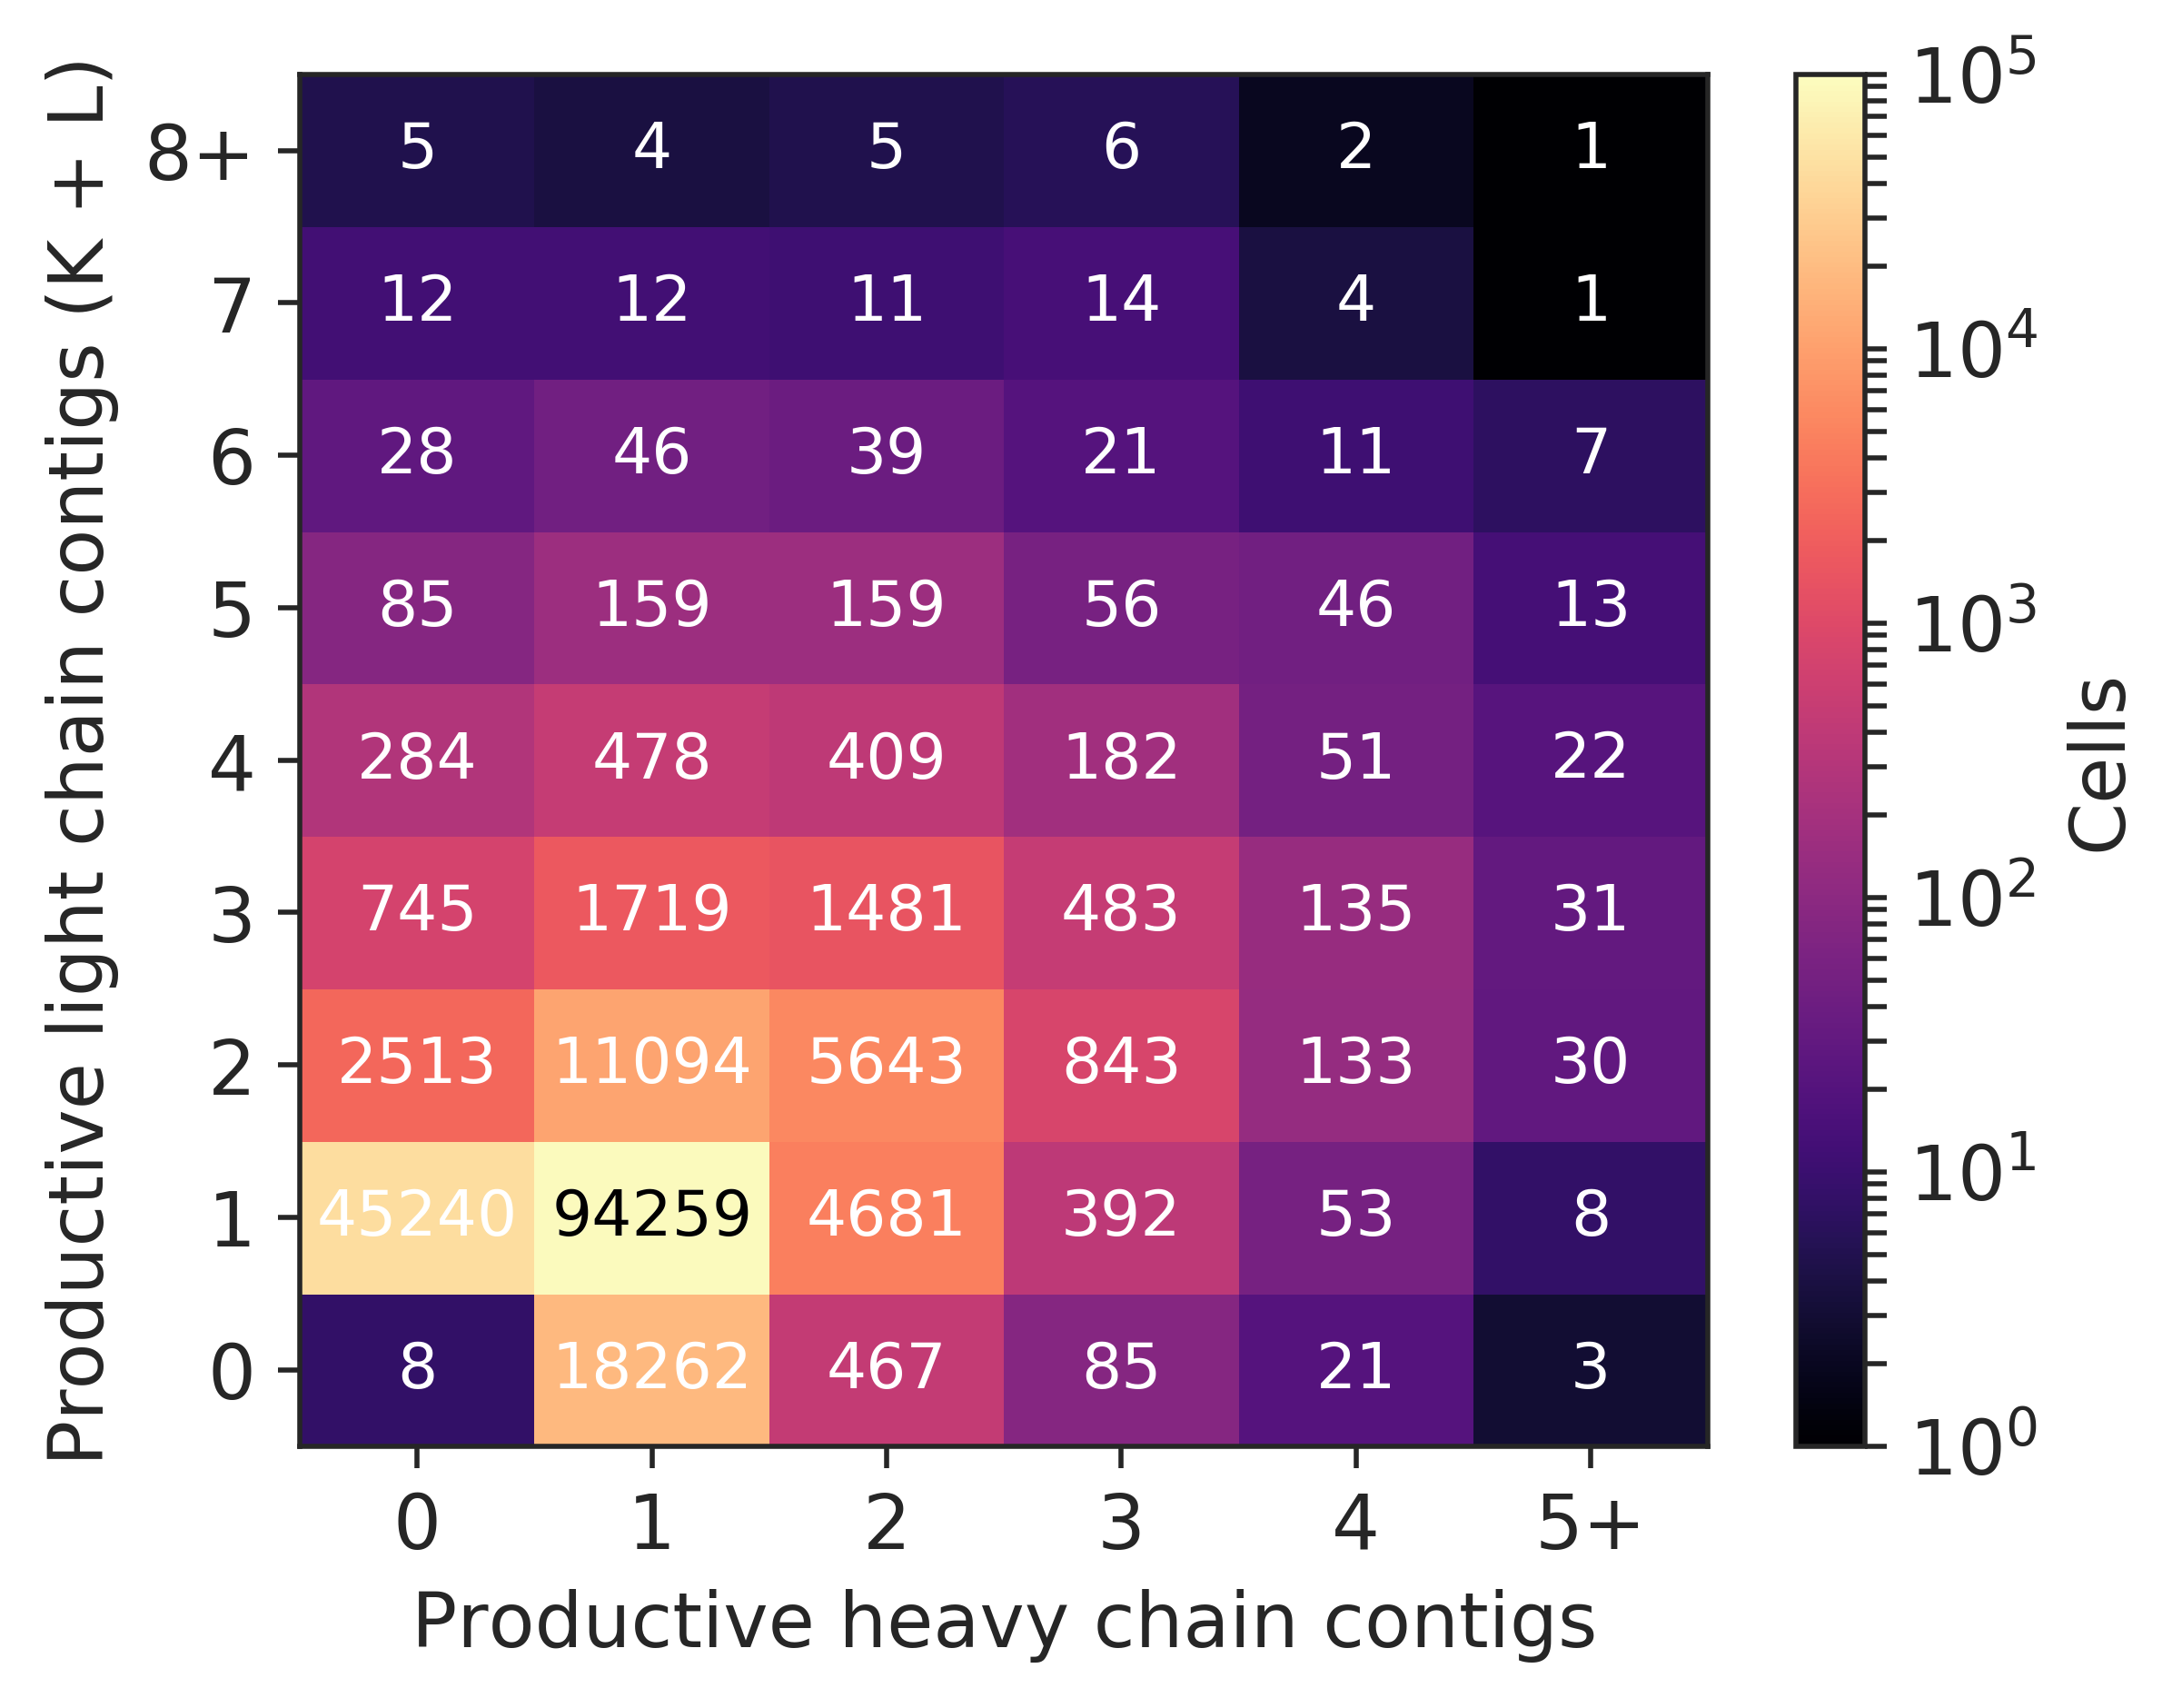

In [13]:
# Examine number of high-quality contigs assembled per cell (joint distribution of IGH, IGK/L)
# cut off to focus on main part of the distribution

df_contig_aggr_filtered_copy = df_contig_aggr_filtered.copy(deep=True) # copy the data so we don't edit the original

# set upper limits of range
xlim_right = 5.5
ylim_top = 8.5

# select data
x = df_contig_aggr_filtered_copy["IGH"]
y = df_contig_aggr_filtered_copy["IGL"] + df_contig_aggr_filtered_copy["IGK"]

# clip data beyond upper limits of range
x[x > xlim_right] = xlim_right - 0.5
y[y > ylim_top] = ylim_top - 0.5

# set bins according to range
xbins = np.array(range(0,int(max(x)+2)))-0.5
ybins = np.array(range(0,int(max(y)+2)))-0.5

# plot

fig, ax = plt.subplots(1, 1, figsize=(5,4))

counts, xedges, yedges, im = ax.hist2d(x, y, bins=(xbins, ybins),
                                       cmap="magma",
                                       norm=mpl.colors.LogNorm(1, 1e5))

ax.set_xlabel("Productive heavy chain contigs")
ax.set_ylabel("Productive light chain contigs (K + L)")
plt.colorbar(im, ax=ax, label="Cells")

ax.set_xlim(right=xlim_right)
ax.set_ylim(top=ylim_top)

# show counts
dx = xedges[2]-xedges[1]
dy = yedges[2]-yedges[1]
for i in range(xedges.size-1):
    for j in range(yedges.size-1):
        if i > xlim_right or j > ylim_top: continue
        xb = xedges[i] + 0.5*dx
        yb = yedges[j] + 0.5*dy 
        ax.text(xb, yb, str(int(counts[i,j])), fontsize=10, ha="center", va="center", color="w")

# show count of 1H+1L in black
xb = xedges[1] + 0.5*dx
yb = yedges[1] + 0.5*dy 
ax.text(xb, yb, str(int(counts[1,1])), fontsize=10, ha="center", va="center", color="k")

# relabel ticks to indicate clipping
ax.set_xticklabels(["dummy", 0, 1, 2, 3, 4, "5+"])
ax.set_yticklabels(["dummy", 0, 1, 2, 3, 4, 5, 6, 7, "8+"])

save_figure(fig, "productive_contigs")

# Filter for singlet cells (having exactly 1 IGH and 1 IGK/L)

In [14]:
# Filter for cells having exactly 1H+1L
df = df_contig_aggr_filtered.loc[(df_contig_aggr_filtered["IGH"] == 1) &
                                 (((df_contig_aggr_filtered["IGL"] == 1) & (df_contig_aggr_filtered["IGK"] == 0)) |
                                  ((df_contig_aggr_filtered["IGL"] == 0) & (df_contig_aggr_filtered["IGK"] == 1)))]
df.head()

# Filter contigs for these cells
df_all_contig_annotations_valid = df_all_contig_annotations.set_index(["sample", "barcode"]).loc[df.index]
print df_all_contig_annotations_valid.shape

# Filter contigs for only IGH, IGL, or IGK
df_all_contig_annotations_valid = df_all_contig_annotations_valid.loc[df_all_contig_annotations_valid["chain"].isin(["IGH", "IGL", "IGK"])]
print df_all_contig_annotations_valid.shape
df_all_contig_annotations_valid.head()

# Filter contigs for only productive
df_all_contig_annotations_valid = df_all_contig_annotations_valid.loc[df_all_contig_annotations_valid["productive"] == "True"]
print df_all_contig_annotations_valid.shape
df_all_contig_annotations_valid.head()

(359321, 17)
(262058, 17)
(188518, 17)


is_cell                    contig_id  high_confidence  length chain      v_gene    d_gene j_gene c_gene  full_length productive                        cdr3                                            cdr3_nt  reads  umis raw_clonotype_id         raw_consensus_id
sample           barcode                                                                                                                                                                                                                                                                                  
023-002_D7_Lane1 AAACCTGAGGCGCTCT-1     True  AAACCTGAGGCGCTCT-1_contig_1             True     559   IGH  IGHV1-69-2  IGHD6-19  IGHJ4   IGHM         True       True            CARGWLESNYAPSDYW   TGTGCGAGAGGGTGGCTGGAATCAAACTACGCACCCTCCGACTACTGG  11418    36      clonotype82  clonotype82_consensus_2
                 AAACCTGAGGCGCTCT-1     True  AAACCTGAGGCGCTCT-1_contig_2             True     577   IGK    IGKV3-20      None  IGKJ2   IGKC         True       True                 CQQYGSSPYTF                  TGTCAGCAGTATGGTAGCTCACCCTACACTTTT   7436    27      clonotype82  clonotype82_consensus_1
                 AAACCTGAGTTAACGA-1     True  AAACCTGAGTTAACGA-1_contig_3             True     641   IGH    IGHV3-74  IGHD4-23  IGHJ4  IGHA2         True       True                CTSHINWRWDYW               TGCACAAGCCACATAAATTGGCGGTGGGACTACTGG    363     1      clonotype83  clonotype83_consensus_2
                 AAACCTGAGTTAACGA-1     True  AAACCTGAGTTAACGA-1_contig_5             True     642   IGL    IGLV2-14      None  IGLJ1  IGLC1         True       True                CGSFTTGGADVF               TGCGGCTCATTCACAACAGGTGGCGCGGATGTCTTC   3494    26      clonotype83  clonotype83_consensus_1
                 AAACCTGCAAAGTCAA-1     True  AAACCTGCAAAGTCAA-1_contig_1             True     587   IGH    IGHV4-61  IGHD3-22  IGHJ3   IGHM         True       True  CARGGRYDSSGYHDRRGFYQYGMDVW  TGTGCGAGAGGGGGCCGGTATGATAGTAGTGGTTATCACGACCGAA...   1590     4      clonotype84  clonotype84_consensus_2

In [15]:
# Filter contigs for only IGH (for mapping into repertoire)
df_all_contig_annotations_valid_IGH = df_all_contig_annotations_valid.loc[df_all_contig_annotations_valid["chain"].isin(["IGH"])]
print df_all_contig_annotations_valid_IGH.shape
df_all_contig_annotations_valid_IGH.head()

(94259, 17)


is_cell                    contig_id  high_confidence  length chain      v_gene    d_gene j_gene c_gene  full_length productive                        cdr3                                            cdr3_nt  reads  umis raw_clonotype_id         raw_consensus_id
sample           barcode                                                                                                                                                                                                                                                                                  
023-002_D7_Lane1 AAACCTGAGGCGCTCT-1     True  AAACCTGAGGCGCTCT-1_contig_1             True     559   IGH  IGHV1-69-2  IGHD6-19  IGHJ4   IGHM         True       True            CARGWLESNYAPSDYW   TGTGCGAGAGGGTGGCTGGAATCAAACTACGCACCCTCCGACTACTGG  11418    36      clonotype82  clonotype82_consensus_2
                 AAACCTGAGTTAACGA-1     True  AAACCTGAGTTAACGA-1_contig_3             True     641   IGH    IGHV3-74  IGHD4-23  IGHJ4  IGHA2         True       True                CTSHINWRWDYW               TGCACAAGCCACATAAATTGGCGGTGGGACTACTGG    363     1      clonotype83  clonotype83_consensus_2
                 AAACCTGCAAAGTCAA-1     True  AAACCTGCAAAGTCAA-1_contig_1             True     587   IGH    IGHV4-61  IGHD3-22  IGHJ3   IGHM         True       True  CARGGRYDSSGYHDRRGFYQYGMDVW  TGTGCGAGAGGGGGCCGGTATGATAGTAGTGGTTATCACGACCGAA...   1590     4      clonotype84  clonotype84_consensus_2
                 AAACCTGCAAGACGTG-1     True  AAACCTGCAAGACGTG-1_contig_4             True     604   IGH    IGHV3-48   IGHD2-2  IGHJ4   IGHM         True       True       CARDISSVVVPAAMGPDFDYW  TGTGCGAGAGACATATCGAGTGTAGTAGTACCAGCTGCTATGGGTC...   6979    27      clonotype85  clonotype85_consensus_1
                 AAACCTGCAATGAAAC-1     True  AAACCTGCAATGAAAC-1_contig_1             True     570   IGH    IGHV4-39  IGHD3-10  IGHJ4   IGHM         True       True      CARRGLDYYGSGSYYKRYFDYW  TGTGCGAGACGGGGTTTGGATTACTATGGTTCGGGGAGTTATTATA...   7204    22      clonotype86  clonotype86_consensus_2

In [16]:
# Write results to files
# df_all_contig_annotations_valid.to_csv("all_contig_annotations.valid.csv")
# df_all_contig_annotations_valid_IGH.to_csv("all_contig_annotations.valid.IGH.csv")

# Plot summary of loading, sequencing, and assembly performance

In [17]:
# Aggregate data for plotting

# count cells having 1+ IGH and 1+ IGK/L
selector = (df_contig_aggr_filtered["IGH"] > 0) & ((df_contig_aggr_filtered["IGK"] + df_contig_aggr_filtered["IGL"]) > 0)
df_temp = df_contig_aggr_filtered.loc[selector]

data = {"Target loading": 15000*12 + 10000*4,
        "Sequenced": sum(df_metrics_summary["Estimated Number of Cells"]),
        "Assembled 1+ IGH and 1+ IGK/L": df_temp.shape[0],
        "Singlets": df_all_contig_annotations_valid_IGH.shape[0]}

dfx = pd.DataFrame(data=data, index=[0])
dfx

,Assembled 1+ IGH and 1+ IGK/L,Sequenced,Singlets,Target loading
0,122744,131585,94259,220000


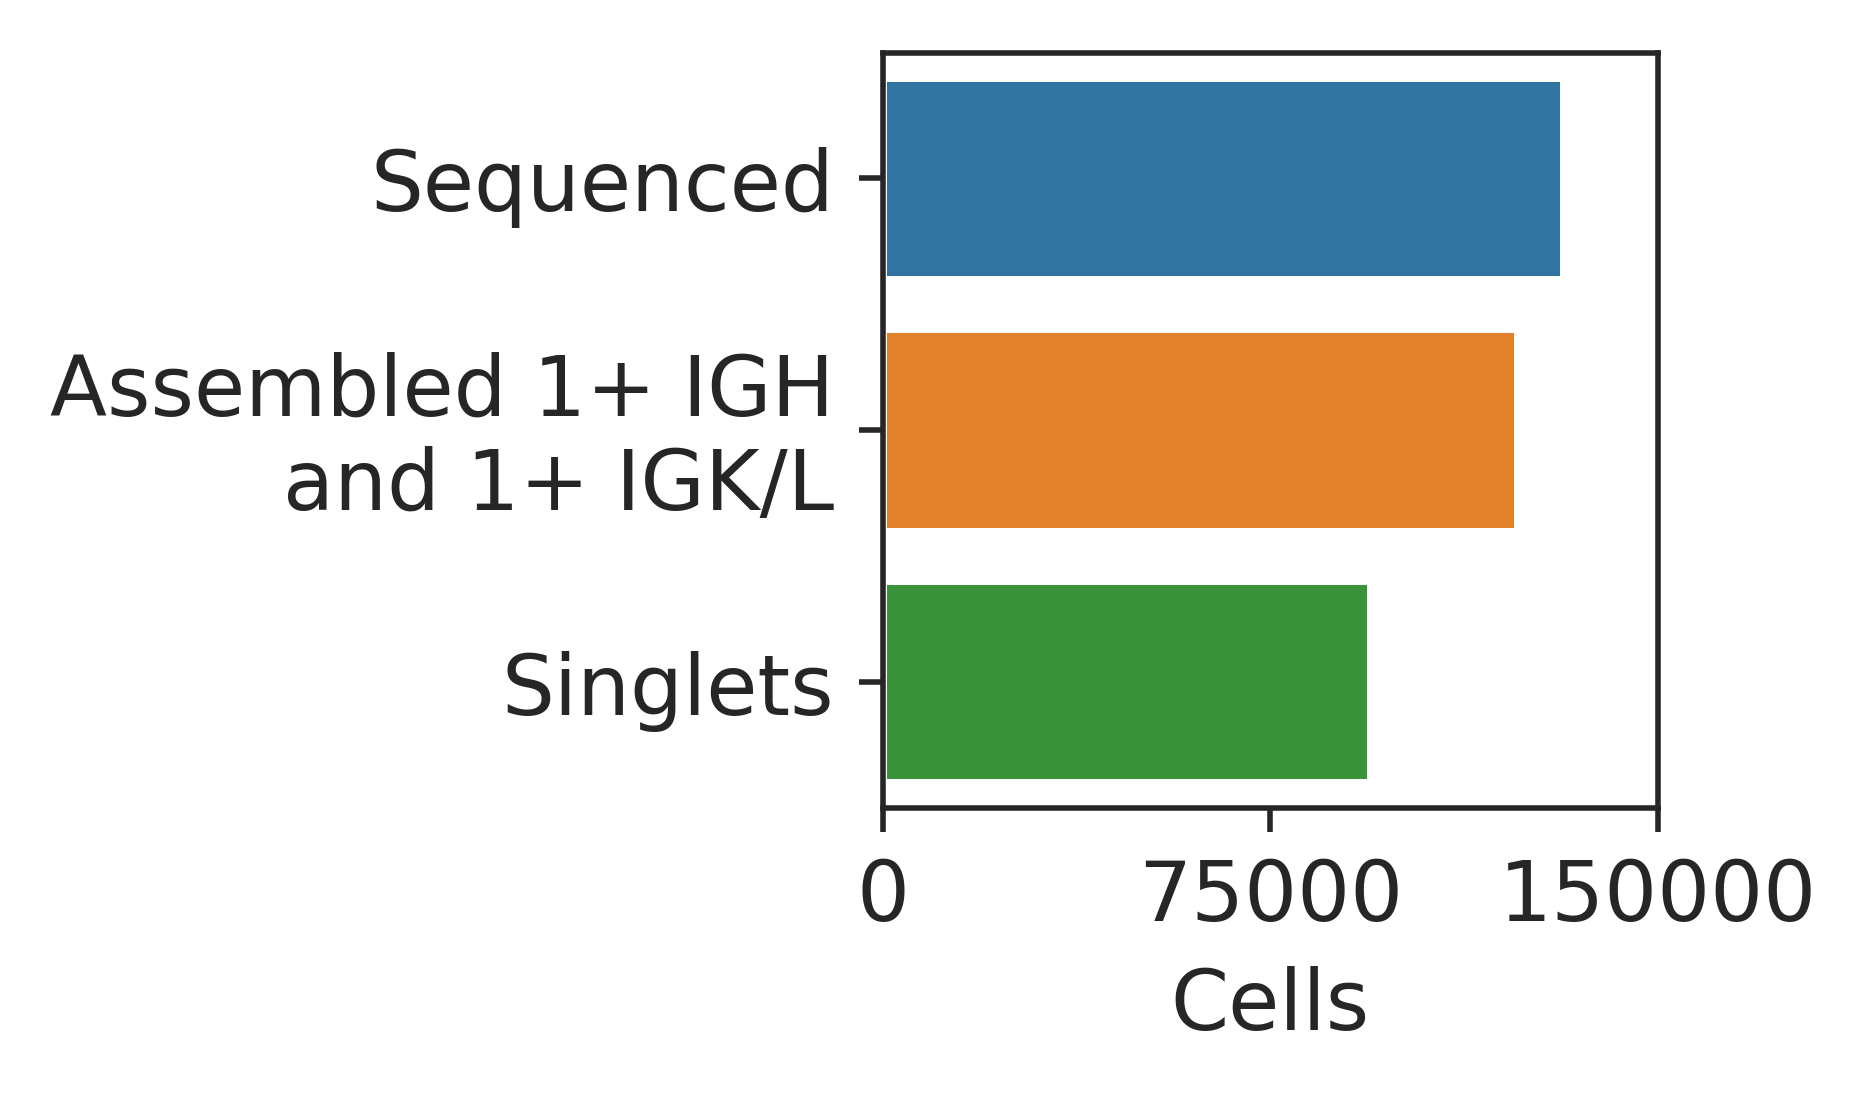

In [18]:
# Plot

fig, ax = plt.subplots(1, 1, figsize=(2,2))
columns = ["Sequenced", "Assembled 1+ IGH and 1+ IGK/L", "Singlets"]
sns.barplot(ax=ax, data=dfx[columns], orient="h")
ax.set_xlim(0,150000)
# ax.set_xscale("log")
# ax.set_xlim(1e4,1e6)
ax.set_xlabel("Cells")
ax.set_yticklabels(["Sequenced", "Assembled 1+ IGH\nand 1+ IGK/L", "Singlets"])
ax.set_xticks([0,75000,150000])

save_figure(fig, "sequenced_assembled_singlets")

## Plot UMIs per contig

Text(0,0.5,'Cells')

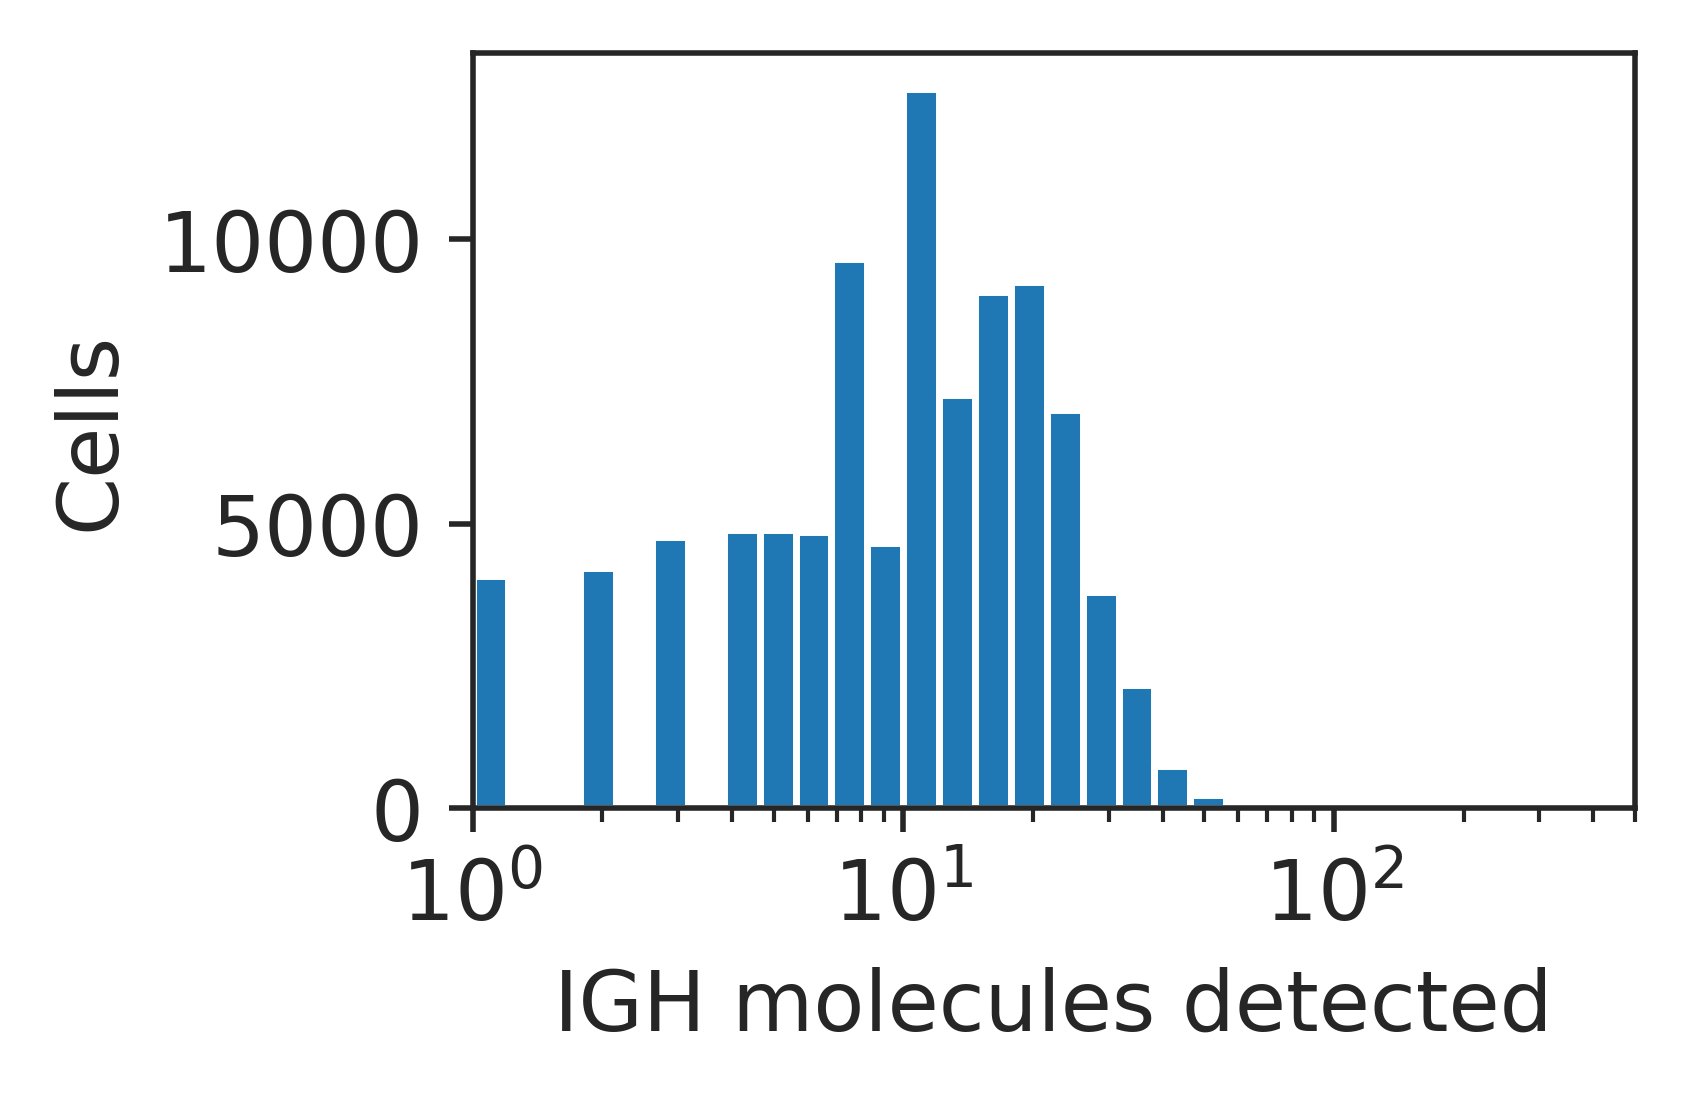

In [19]:
# IGH (looks crappy because of binning)

# select data
selector = df_all_contig_annotations_valid["chain"] == "IGH"
x = df_all_contig_annotations_valid.loc[selector]["umis"]

# bins = list(np.linspace(0,50,51)) + [100, 200, 300]
bins = np.logspace(0, 2, 25)

fig, ax = plt.subplots(1, 1, figsize=(3,2))
ax.hist(x, bins=bins)
ax.set_xscale("log")
ax.set_ylim(bottom=0)
ax.set_xlim(1,500)
ax.set_xlabel("IGH molecules detected")
ax.set_ylabel("Cells")

/scratch/resources/anaconda2/envs/py27/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0,0,'IGH'), Text(0,0,'IGK/L')]

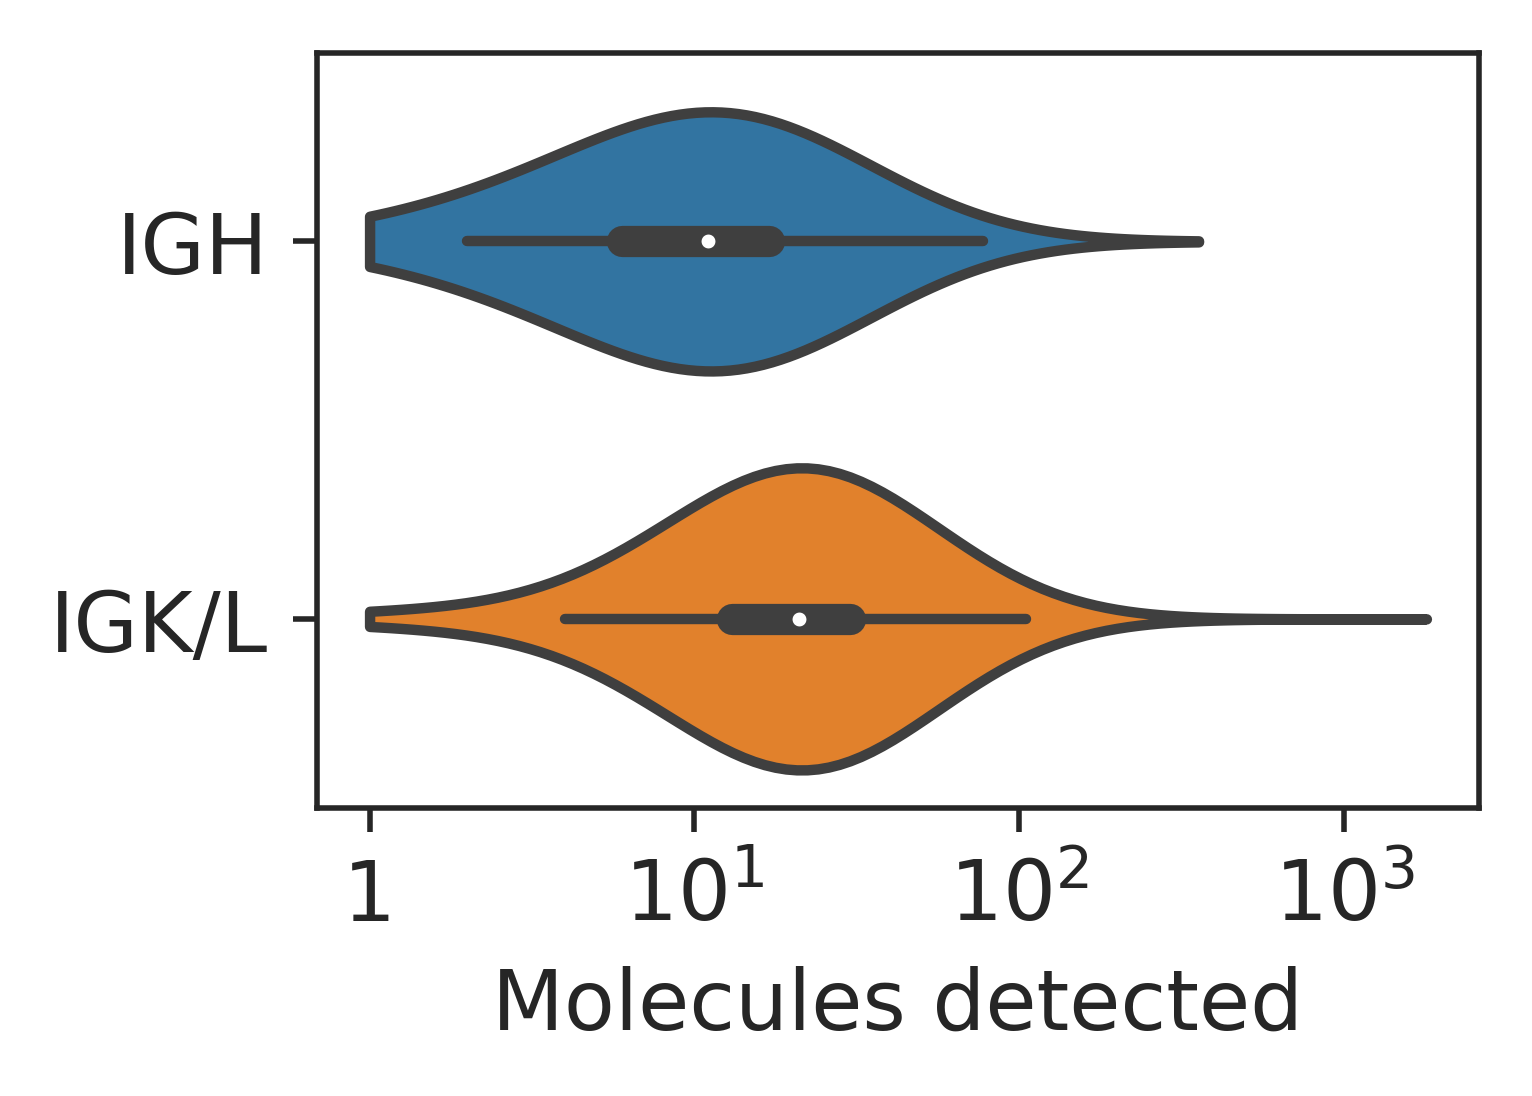

In [20]:
# IGH and IGK/L

# select data
selector = df_all_contig_annotations_valid["chain"] == "IGH"
x1 = df_all_contig_annotations_valid.loc[selector]["umis"]
x1 = np.log10(x1)

selector = (df_all_contig_annotations_valid["chain"] == "IGK") | (df_all_contig_annotations_valid["chain"] == "IGL")
x2 = df_all_contig_annotations_valid.loc[selector]["umis"]
x2 = np.log10(x2)

# plot
fig, ax = plt.subplots(1, 1, figsize=(3,2))
sns.violinplot(data=[x1, x2], ax=ax, orient="h", cut=0, bw=1)
ax.set_xlabel("Molecules detected")
ax.set_xticklabels(["dummy", "1", "$10^1$", "$10^2$",  "$10^3$"])
ax.set_yticklabels(["IGH", "IGK/L"])

# Plot basic descriptive features (IGH, IGKL gene usage, isotype)

# Isotype

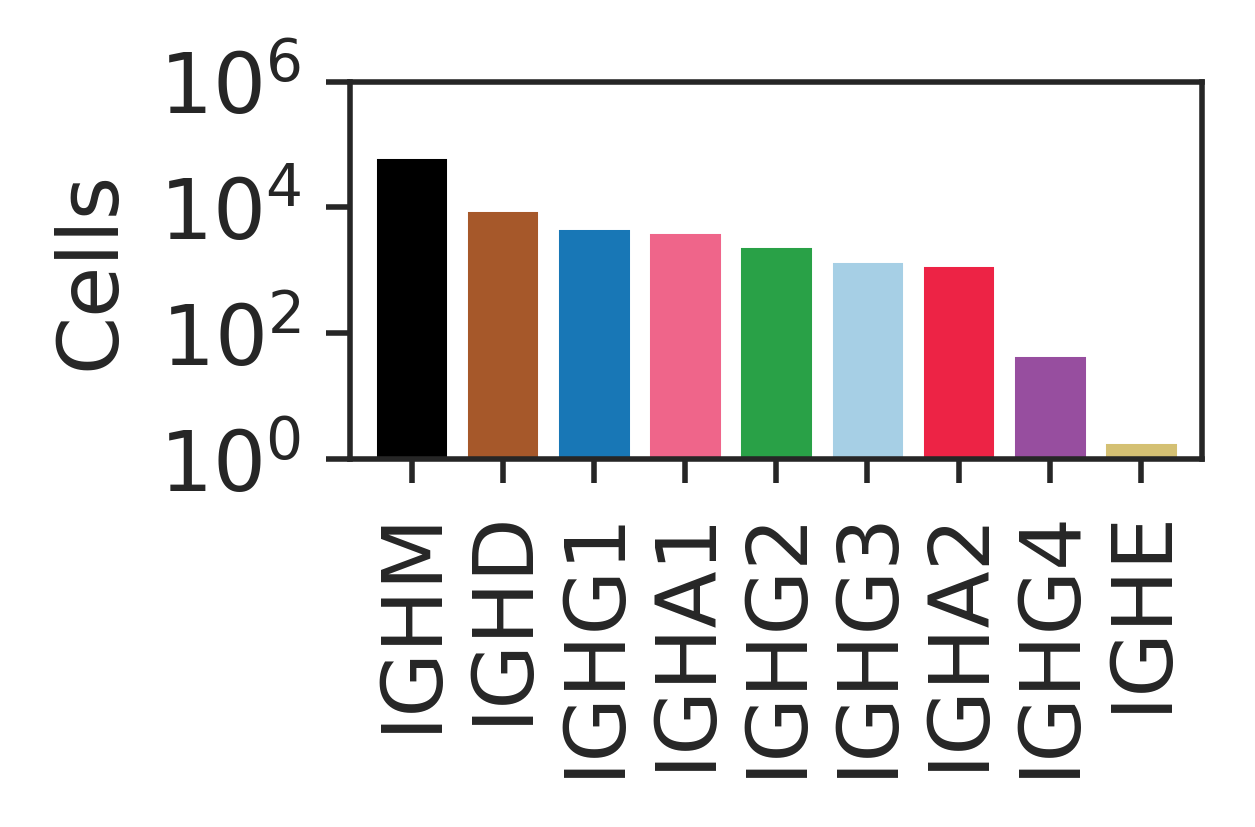

In [21]:
# Classic color scheme from Horns et al. PNAS 2019
isotype_to_color = {"IGHM": "#000000", 
                    "IGHD": "#a6582a",
                    "IGHG1": "#1877b6",
                    "IGHG2": "#29a147",
                    "IGHG3": "#a6cfe5",
                    "IGHG4": "#974e9f",
                    "IGHA1": "#ef658a",
                    "IGHA2": "#ed2345",
                    "IGHE": "#d4c073",
                    "Not detected": "#999999"}

x = df_all_contig_annotations_valid_IGH["c_gene"].value_counts().drop("None")
palette = [isotype_to_color[i] for i in x.index]

fig, ax = plt.subplots(1, 1, figsize=(2.2,1))
x.plot(kind="bar", ax=ax, width=0.85, color=palette)
ax.set_yscale("log")
ax.set_ylim(1,1e6)
ax.set_yticks([1, 1e2, 1e4, 1e6])
ax.set_ylabel("Cells")

save_figure(fig, "isotype")

In [22]:
# Show counts
x = df_all_contig_annotations_valid_IGH["c_gene"].value_counts().drop("None")
x

IGHM     69043
IGHD      9882
IGHG1     5032
IGHA1     4333
IGHG2     2671
IGHG3     1493
IGHA2     1312
IGHG4       49
IGHE         2
Name: c_gene, dtype: int64